## Imports

In [2]:
import time

import numpy as np
import cv2 as cv
import os
import glob
import matplotlib.pyplot as plt
from numpy.random import uniform
import pdb
from tqdm import tqdm



## Show functions

In [24]:
def show_image_cv(title,image,fx=1,fy=1,output = True):

    if not output:
        return

    image = cv.resize(image,(0,0),fx=fx,fy=fy)
    cv.imshow(title, image)
    cv.waitKey(0)
    cv.destroyAllWindows()

def show_image_matplot(title, image,fx=1,fy=1,output = True):
    if not output:
        return

    image_resized = cv.resize(image, (0, 0), fx=fx, fy=fy)

    image = cv.cvtColor(image_resized, cv.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Ascunde axele pentru a afișa doar imaginea
    plt.show()

## Directory and files functions

In [4]:
def get_image_paths(dir,index):
    image_paths = os.listdir(dir)
    image_paths = ["./" + dir + "/" + file for file in image_paths if file[0:2] == str(index) + "_" and file[-4:] == ".jpg"]
    return sorted(image_paths)


## HSV masking

In [5]:
# hsv mask

def get_outer_masked_image(img,output = False):
    lower_hsv_bound = np.array([20,0,0])
    upper_hsv_bound = np.array([255,255,255])
    hsv_image = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    mask = cv.inRange(hsv_image, lower_hsv_bound, upper_hsv_bound)
    show_image_cv("mask",mask,output = output)

    new_image = cv.bitwise_and(img, img, mask=mask)
    show_image_cv("ceva",new_image,output = output)

    return new_image



## Get game contour function


In [6]:
def get_game_countour(image,output = False):

    masked_image = get_outer_masked_image(image)
    masked_image_grey = cv.cvtColor(masked_image, cv.COLOR_BGR2GRAY)

    show_image_cv("masked_image_grey",masked_image_grey,output = output)

    masked_image_grey = cv.medianBlur(masked_image_grey,3)
    show_image_cv('median_blur_image',masked_image_grey,output = output)

    contours, _ = cv.findContours(masked_image_grey,  cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    max_area = 0
    for i in range(len(contours)):
            if(len(contours[i]) >3):
                possible_top_left = None
                possible_bottom_right = None
                for point in contours[i].squeeze():
                    if possible_top_left is None or point[0] + point[1] < possible_top_left[0] + possible_top_left[1]:
                        possible_top_left = point

                    if possible_bottom_right is None or point[0] + point[1] > possible_bottom_right[0] + possible_bottom_right[1] :
                        possible_bottom_right = point

                diff = np.diff(contours[i].squeeze(), axis = 1)
                possible_top_right = contours[i].squeeze()[np.argmin(diff)]
                possible_bottom_left = contours[i].squeeze()[np.argmax(diff)]
                if cv.contourArea(np.array([[possible_top_left],[possible_top_right],[possible_bottom_right],[possible_bottom_left]])) > max_area:
                    max_area = cv.contourArea(np.array([[possible_top_left],[possible_top_right],[possible_bottom_right],[possible_bottom_left]]))
                    top_left = possible_top_left
                    bottom_right = possible_bottom_right
                    top_right = possible_top_right
                    bottom_left = possible_bottom_left


    image_copy = cv.cvtColor(masked_image_grey.copy(),cv.COLOR_GRAY2BGR)
    cv.circle(image_copy,tuple(top_left),20,(0,0,255),-1)
    cv.circle(image_copy,tuple(top_right),20,(0,0,255),-1)
    cv.circle(image_copy,tuple(bottom_left),20,(0,0,255),-1)
    cv.circle(image_copy,tuple(bottom_right),20,(0,0,255),-1)
    show_image_cv("detected corners",image_copy,output = output)


    width = 810
    height = 810

    puzzle = np.array([top_left,top_right,bottom_left,bottom_right],dtype=np.float32)
    destination = np.array([[0,0],[width,0],[0,height],[width,height]],dtype=np.float32)
    M = cv.getPerspectiveTransform(puzzle,destination)
    result = cv.warpPerspective(image,M,(width,height))

    return result

## Game table extractor

In [7]:
def extract_game(image_paths,size = 1000):
    images = []
    size = size if size <= len(image_paths) else len(image_paths)
    for i in tqdm(range(size)):
        img = cv.imread(image_paths[i])
        result = get_game_countour(img)
        images.append(result)
    return np.array(images)

def strip_margins(img,output = False):

    img = img.copy()
    img_grey = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    BLACK = 0

    height,width,_ = img.shape

    # somewhere between 13% and 14% of the height and width of the image
    top_margin = 107
    bottom_margin = height - 102
    left_margin = 107
    right_margin = width - 105

    img_grey[:top_margin, :] = BLACK
    img_grey[bottom_margin:, :] = BLACK

    img_grey[:, :left_margin] = BLACK
    img_grey[:, right_margin:] = BLACK

    show_image_cv("ceva",img_grey,fx=1,fy=1,output = output)

    masked_image_grey = img_grey

    contours, _ = cv.findContours(masked_image_grey,  cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    max_area = 0
    for i in range(len(contours)):
            if(len(contours[i]) >3):
                possible_top_left = None
                possible_bottom_right = None
                for point in contours[i].squeeze():
                    if possible_top_left is None or point[0] + point[1] < possible_top_left[0] + possible_top_left[1]:
                        possible_top_left = point

                    if possible_bottom_right is None or point[0] + point[1] > possible_bottom_right[0] + possible_bottom_right[1] :
                        possible_bottom_right = point

                diff = np.diff(contours[i].squeeze(), axis = 1)
                possible_top_right = contours[i].squeeze()[np.argmin(diff)]
                possible_bottom_left = contours[i].squeeze()[np.argmax(diff)]
                if cv.contourArea(np.array([[possible_top_left],[possible_top_right],[possible_bottom_right],[possible_bottom_left]])) > max_area:
                    max_area = cv.contourArea(np.array([[possible_top_left],[possible_top_right],[possible_bottom_right],[possible_bottom_left]]))
                    top_left = possible_top_left
                    bottom_right = possible_bottom_right
                    top_right = possible_top_right
                    bottom_left = possible_bottom_left


    image_copy = cv.cvtColor(masked_image_grey.copy(),cv.COLOR_GRAY2BGR)
    cv.circle(image_copy,tuple(top_left),2,(0,0,255),-1)
    cv.circle(image_copy,tuple(top_right),2,(0,0,255),-1)
    cv.circle(image_copy,tuple(bottom_left),2,(0,0,255),-1)
    cv.circle(image_copy,tuple(bottom_right),2,(0,0,255),-1)
    show_image_cv("detected corners",image_copy,output = output,fx=1,fy=1)


    width = 14 * 60
    height = 14 * 60

    puzzle = np.array([top_left,top_right,bottom_left,bottom_right],dtype=np.float32)
    destination = np.array([[0,0],[width,0],[0,height],[width,height]],dtype=np.float32)
    M = cv.getPerspectiveTransform(puzzle,destination)
    result = cv.warpPerspective(img,M,(width,height))

    return result

def extract_relevant_game(images):
    new_images = []

    for image in tqdm(images):
        new_images.append(strip_margins(image))

    return np.array(new_images)


In [8]:
game_tables = extract_game(get_image_paths("antrenare",1))


100%|██████████| 50/50 [00:14<00:00,  3.44it/s]


In [9]:
show_image_cv("txt",game_tables[0],fx=1,fy=1)

In [10]:
relevant_game_tables = extract_relevant_game(game_tables)

100%|██████████| 50/50 [00:00<00:00, 307.08it/s]


## Cell delimiter function

In [11]:

def get_lines_coords():
    lines_horizontal = []
    for i in range(0,14*60+1,60):
        line = []
        line.append((0,i))
        line.append((14*60-1,i))
        lines_horizontal.append(line)

    lines_vertical = []
    for i in range(0,14*60+1,60):
        line = []
        line.append((i,0))
        line.append((i,14*60-1))
        lines_vertical.append(line)

    return lines_vertical,lines_horizontal

def draw_lines(images):

    new_images = images.copy()

    lines_vertical,lines_horizontal = get_lines_coords()

    GREEN = (0,255,0)
    RED = (0,0,255)

    for image in tqdm(new_images):
        for line in lines_vertical:
            cv.line(image,line[0],line[1],GREEN,2)

        for line in lines_horizontal:
            cv.line(image,line[0],line[1],RED,2)

    return new_images


In [12]:
delimited_tables = draw_lines(relevant_game_tables)


100%|██████████| 50/50 [00:00<00:00, 2474.98it/s]


In [13]:
paths = ["./imagini_auxiliare/" + file for file in os.listdir("./imagini_auxiliare")]
test_tables = extract_game(paths)
game_tables = extract_relevant_game(test_tables)

lines = draw_lines(game_tables)

100%|██████████| 4/4 [00:00<00:00, 2246.55it/s]


In [ ]:

def get_pieces_numbers():
    return [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 27, 28, 30, 32, 35, 36, 40, 42, 45, 48, 49, 50, 54, 56, 60, 63, 64, 70, 72, 80, 81, 90]

def store_template_numbers1():

    img = ["./imagini_auxiliare/03.jpg"]
    table = extract_game(img)
    game_table = extract_relevant_game(table)[0]

    piece_values = get_pieces_numbers()
    index = 0
    offset = 10

    for i in range(5 * 60, 9 * 60 +1 ,60):
        for j in range(4 * 60 , 12 * 60, 60):
            frame = game_table[i:i+60 - offset,j:j+60 - offset,:]
            # show_image_matplot("",frame)
            cv.imwrite("./templates/sample1" + str(piece_values[index])+ ".jpg", frame)
            index += 1

    i = 10 * 60

    for j in range(4 * 60 , 10 * 60, 60):
            frame = game_table[i:i+60 - offset,j:j+60 -offset,:]
            # show_image_matplot("",frame)
            cv.imwrite("./templates/sample1/" + str(piece_values[index])+ ".jpg", frame)
            index +=1

def store_template_numbers2():

    img = ["./imagini_auxiliare/04.jpg"]
    table = extract_game(img)
    game_table = extract_relevant_game(table)[0]

    piece_values = get_pieces_numbers()

    index = 0
    offset = 10
    up_offset = 10
    left_offset = 5
    for i in range(0* 60, 14 * 60, 2 * 60):
        for j in range(0* 60 , 14 * 60, 2 * 60):

            if index == len(piece_values):
                return

            frame = game_table[i + up_offset:i+60 - offset,j + left_offset:j+60 - offset,:]
            # show_image_matplot("",frame)
            cv.imwrite("./templates/sample2/" + str(piece_values[index])+ ".jpg", frame)
            index += 1

In [30]:
store_template_numbers2()

100%|██████████| 1/1 [00:00<00:00, 189.75it/s]


## Template extractor from sample images

In [66]:
def store_template_numbers1():

    img = ["./imagini_auxiliare/03.jpg"]
    table = extract_game(img)
    game_table = extract_relevant_game(table)[0]

    lines_vertical,lines_horizontal = get_lines_coords()

    piece_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 27, 28, 30, 32, 35, 36, 40, 42, 45, 48, 49, 50, 54, 56, 60, 63, 64, 70, 72, 80, 81, 90]

    index = 0
    offset = 0

    for i in range(5,11):
        for j in range(4,12):

            if index == len(piece_values):
                return

            y_min = lines_vertical[j][0][0] + offset
            y_max = lines_vertical[j + 1][1][0] - offset
            x_min = lines_horizontal[i][0][1] + offset
            x_max = lines_horizontal[i + 1][1][1] - offset

            patch = game_table[x_min:x_max,y_min:y_max:].copy()
            cv.imwrite("./templates/sample3/" + str(piece_values[index])+ ".jpg", patch)
            index += 1



def store_template_numbers2():

    img = ["./imagini_auxiliare/04.jpg"]
    table = extract_game(img)
    game_table = extract_relevant_game(table)[0]

    lines_vertical,lines_horizontal = get_lines_coords()

    piece_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 27, 28, 30, 32, 35, 36, 40, 42, 45, 48, 49, 50, 54, 56, 60, 63, 64, 70, 72, 80, 81, 90]

    index = 0

    offset = 5

    for i in range(0,len(lines_horizontal)-1,2):
        for j in range(0,len(lines_vertical)-1,2):

            if index == len(piece_values):
                return

            y_min = lines_vertical[j][0][0] + offset
            y_max = lines_vertical[j + 1][1][0] - offset
            x_min = lines_horizontal[i][0][1] + offset
            x_max = lines_horizontal[i + 1][1][1] - offset

            patch = game_table[x_min:x_max,y_min:y_max:].copy()
            cv.imwrite("./templates/sample4/" + str(piece_values[index])+ ".jpg", patch)
            index += 1


def store_thresholded_templates(source_path = "./templates/sample4",destination_path = "./thresholded_templates"):
    paths = sorted(os.listdir(source_path))

    for path in paths:
        img = cv.imread(os.path.join(source_path,path))
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        _, img = cv.threshold(img,80,255,cv.THRESH_BINARY_INV)
        cv.imwrite(os.path.join(destination_path,path), img)



In [67]:
store_template_numbers2()
store_thresholded_templates()

100%|██████████| 1/1 [00:00<00:00, 634.64it/s]


In [87]:
def classify_number(patch):

    maxi = -np.inf
    chosen_number = -1
    numbers = get_pieces_numbers()

    for number in numbers:
        template = cv.imread("./thresholded_templates/" + str(number) + ".jpg")
        template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
        corr = cv.matchTemplate(patch,template,  cv.TM_CCOEFF_NORMED)
        corr=np.max(corr)

        if corr > maxi:
            maxi = corr
            chosen_number = number


    return chosen_number

def get_number_pos(thresholded_image,offset):
    lines_vertical,lines_horizontal = get_lines_coords()

    coords=[]

    for i in range(len(lines_horizontal)-1):
        for j in range(len(lines_vertical)-1):

            y_min = lines_vertical[j][0][0] + offset
            y_max = lines_vertical[j + 1][1][0] - offset
            x_min = lines_horizontal[i][0][1] + offset
            x_max = lines_horizontal[i + 1][1][1] - offset

            patch = thresholded_image[x_min:x_max,y_min:y_max].copy()

            if i==6 and j == 6:
                print(patch)
            mean = np.mean(patch)
            h,w = patch.shape

            if mean > (255 * 15) / (h * w) :
                predicted_number = classify_number(patch)
                coords.append((i,j,predicted_number))
                show_image_matplot("patch" + str(i)+ " " + str(j) + " "+ str(predicted_number), patch)
            else:
                show_image_matplot("patch" + str(i)+ " " + str(j), patch)
    return coords



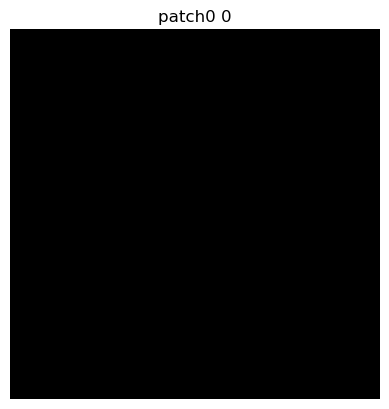

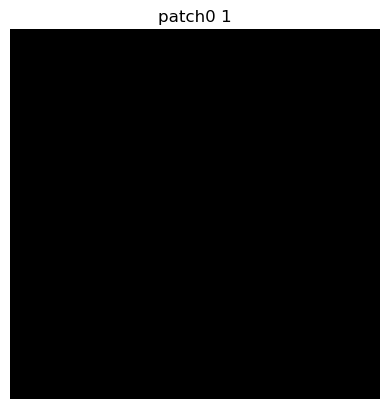

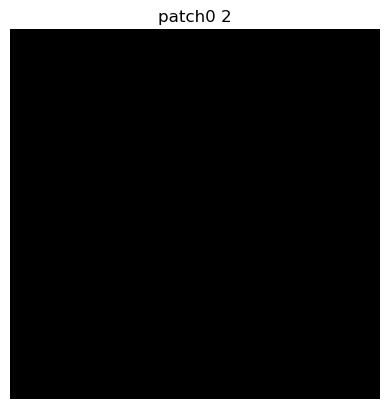

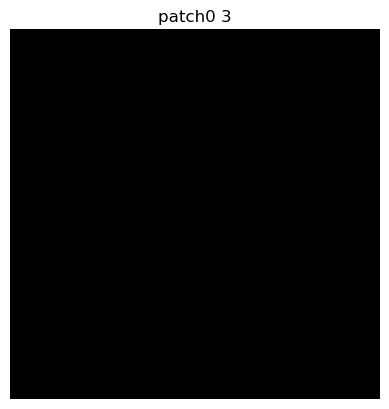

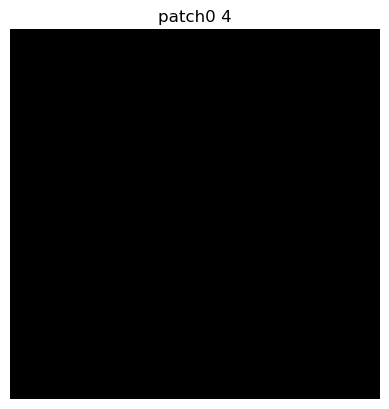

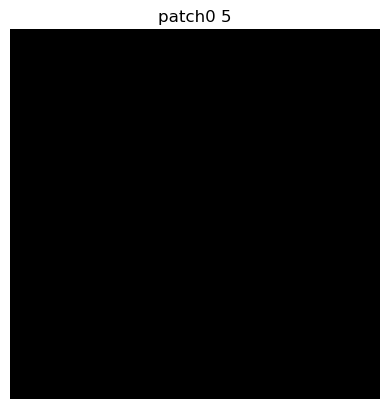

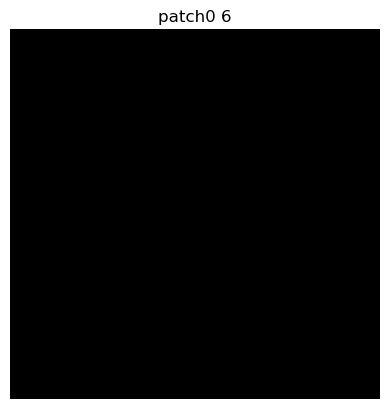

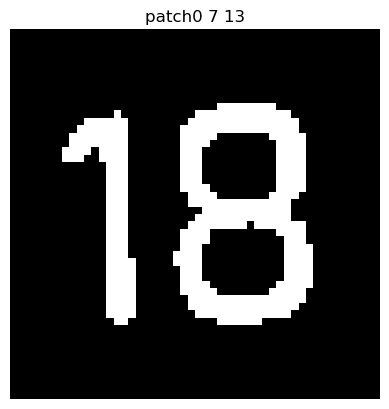

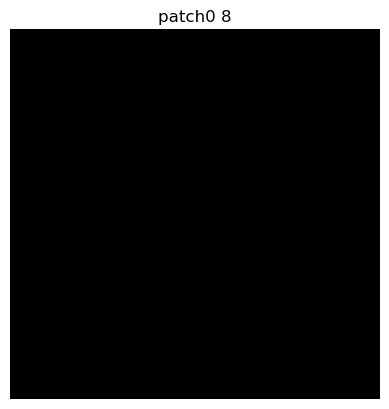

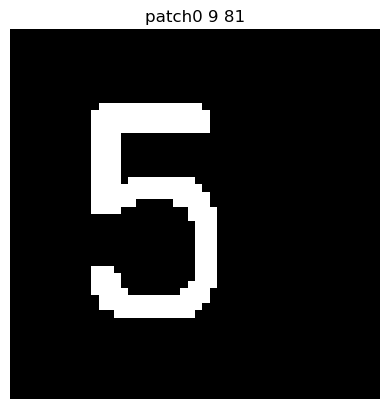

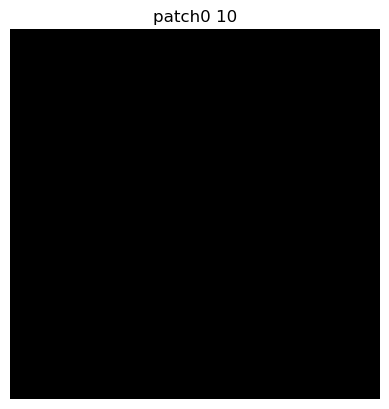

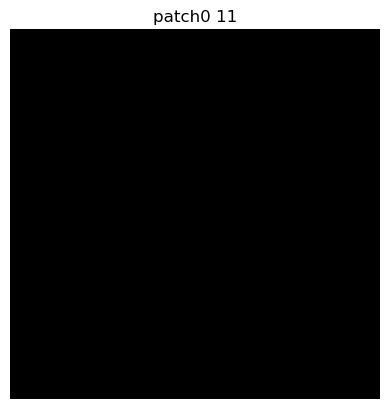

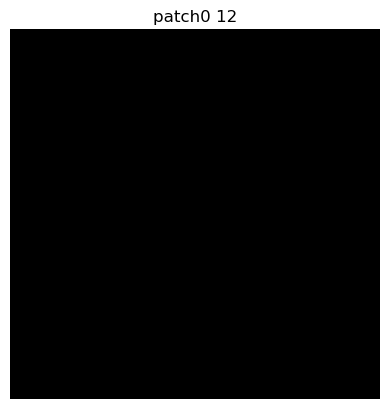

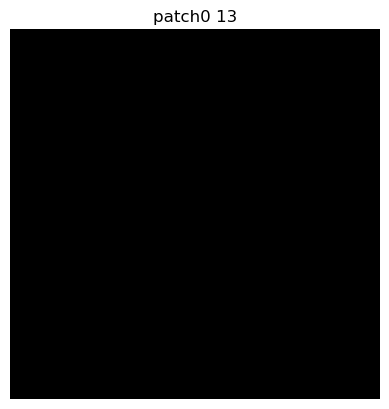

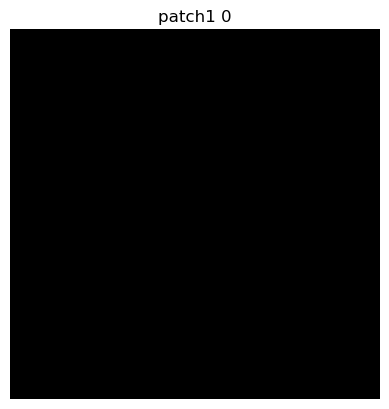

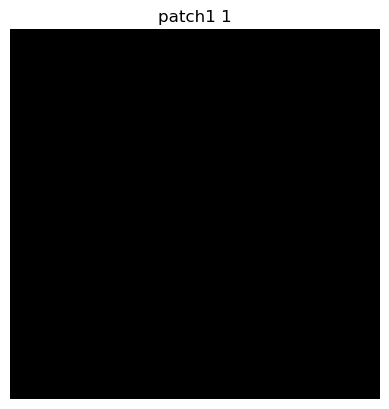

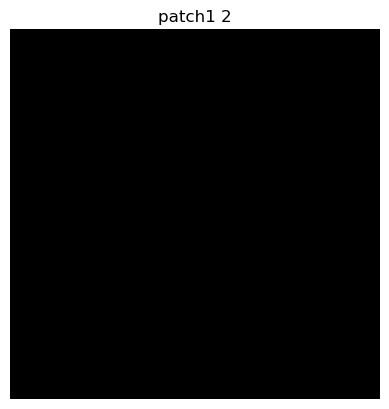

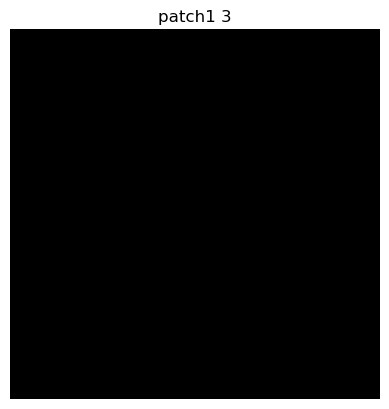

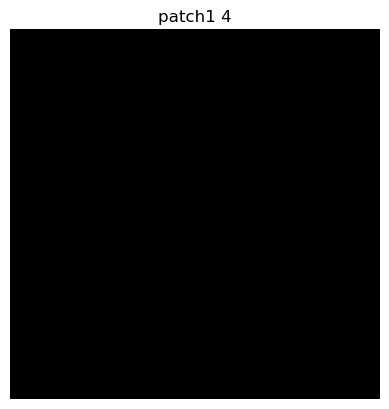

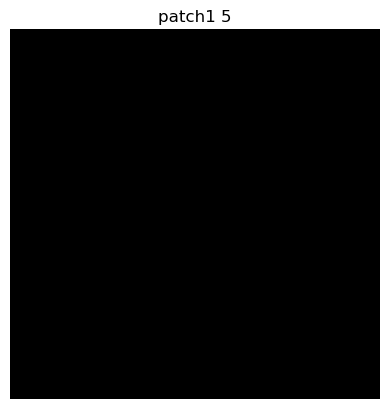

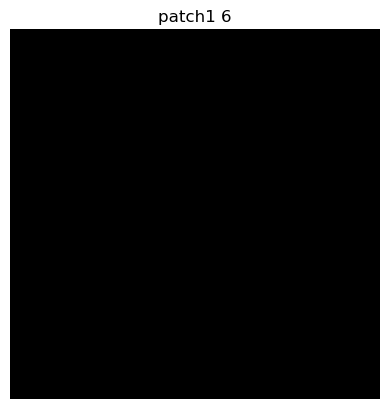

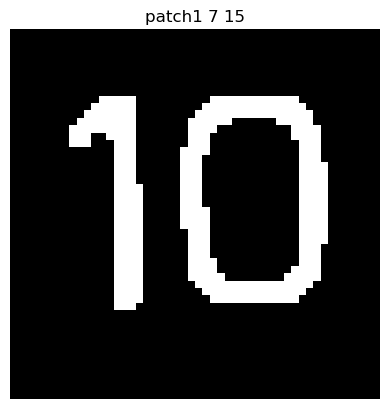

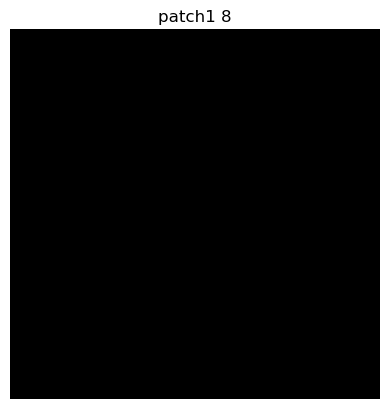

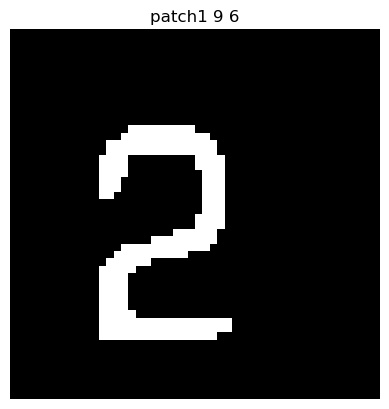

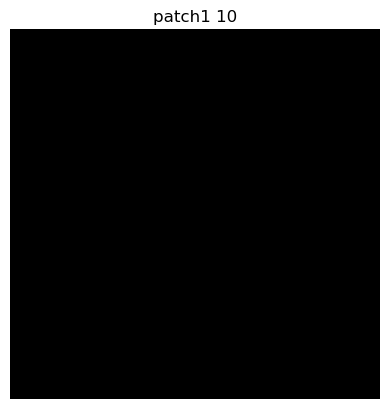

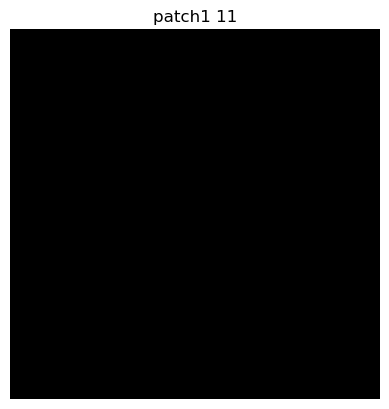

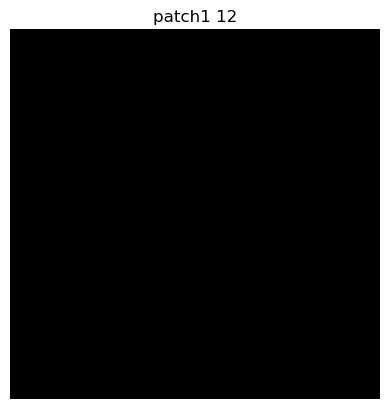

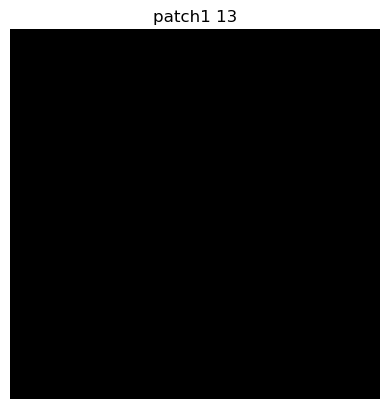

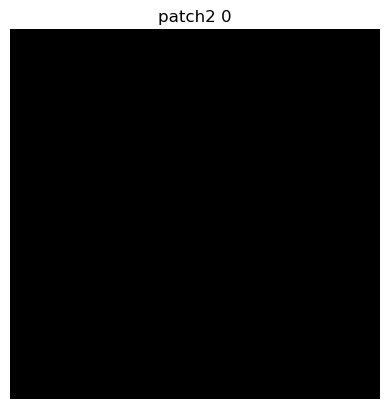

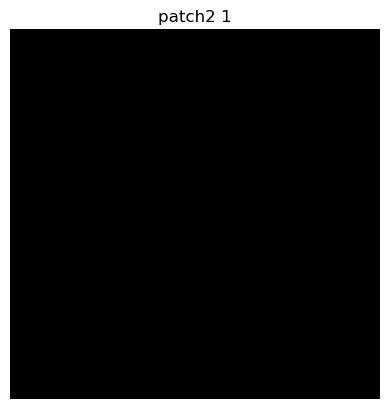

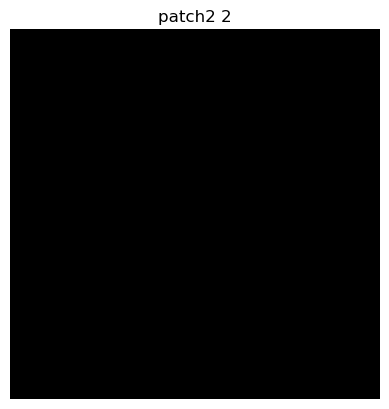

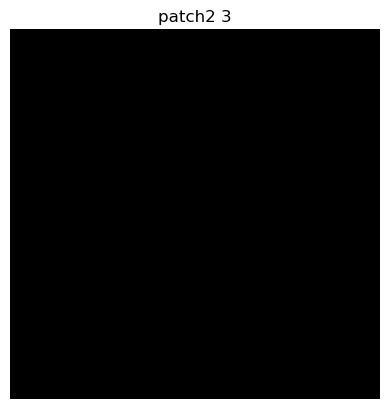

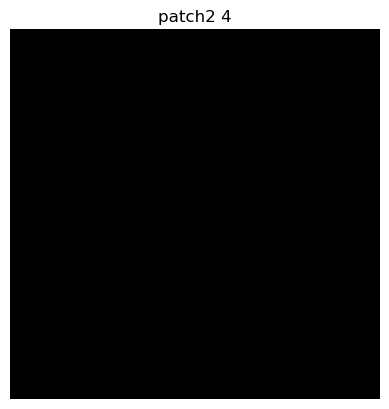

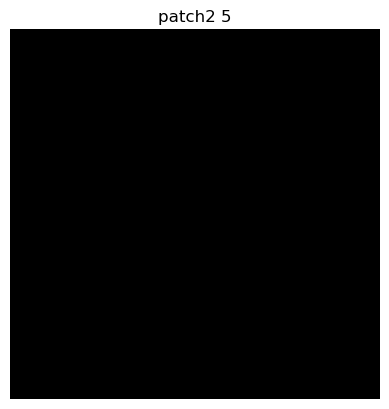

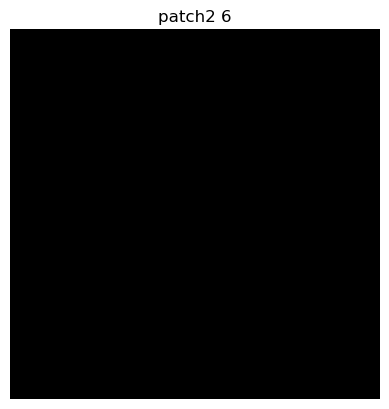

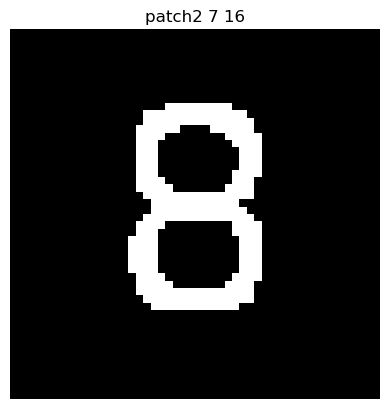

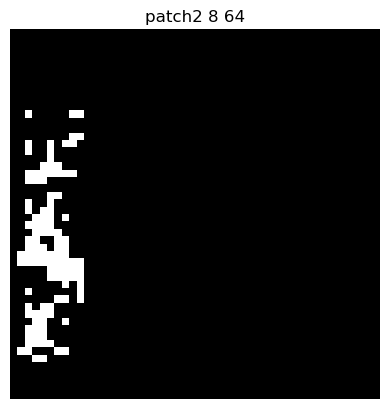

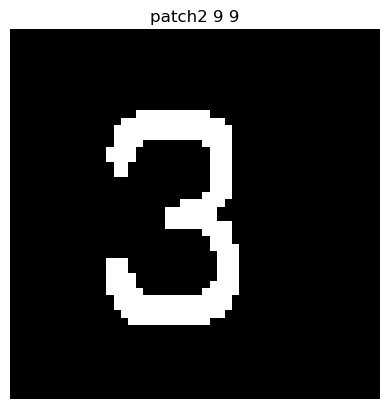

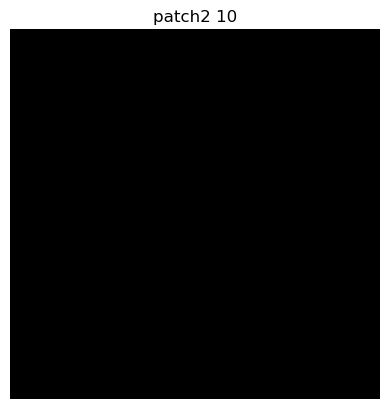

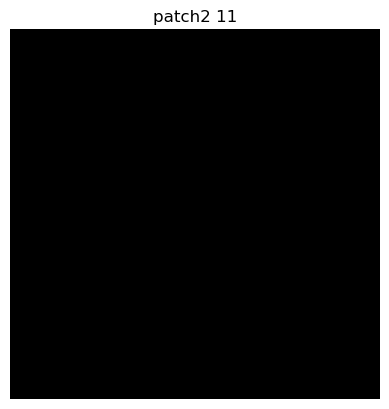

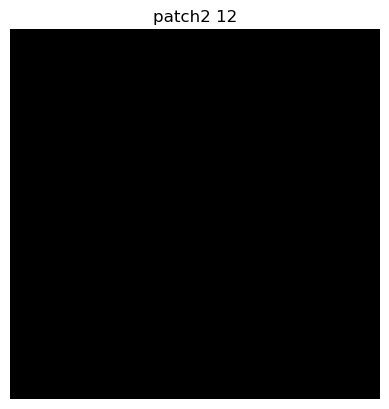

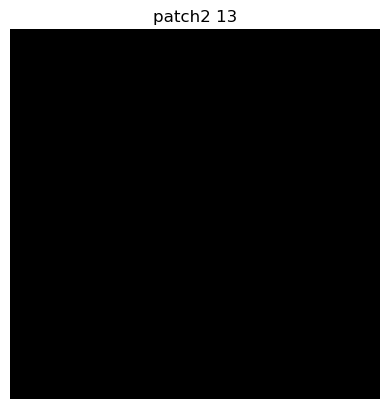

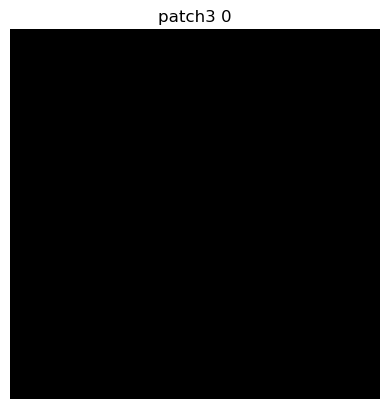

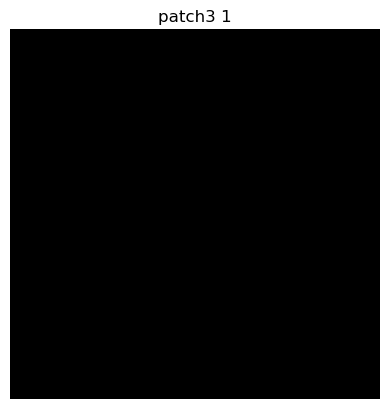

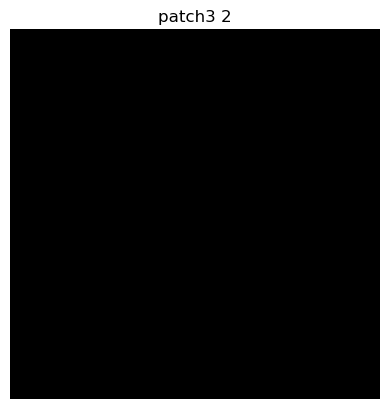

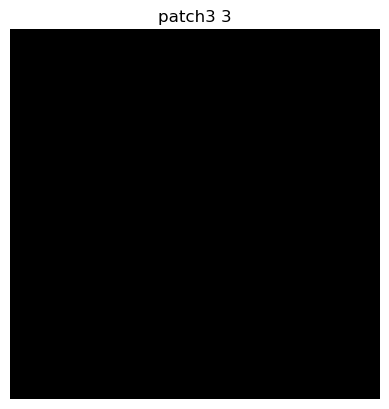

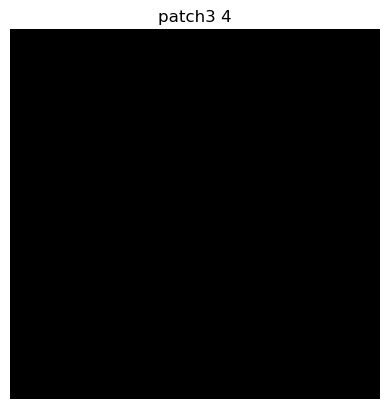

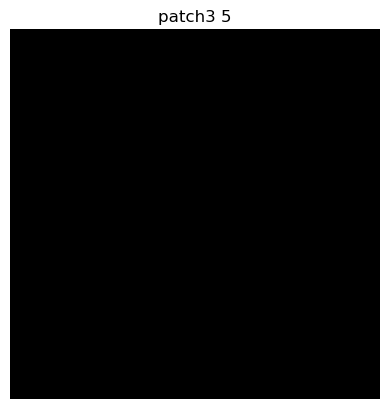

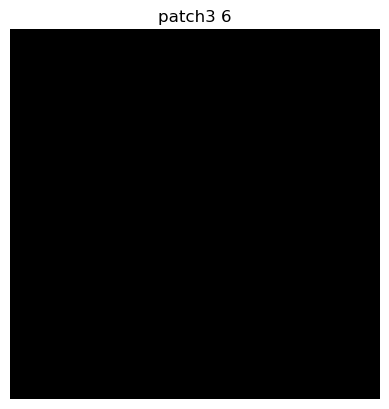

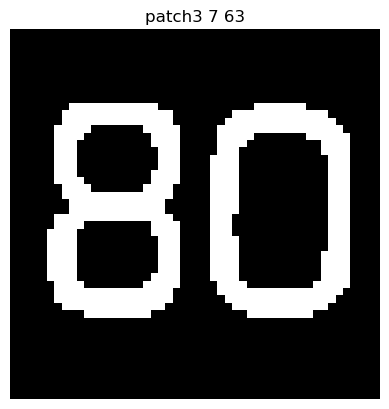

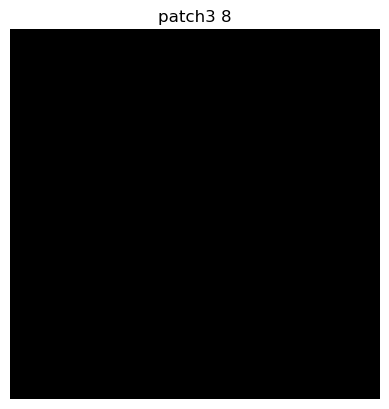

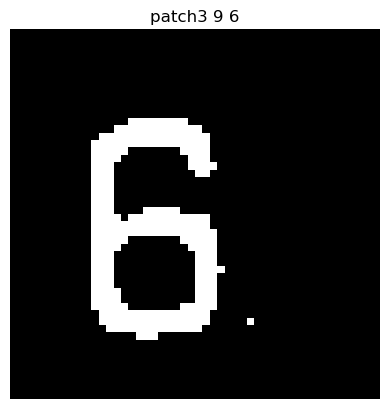

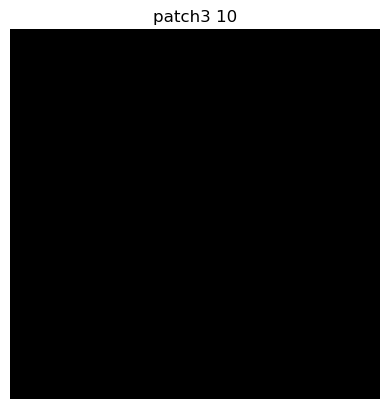

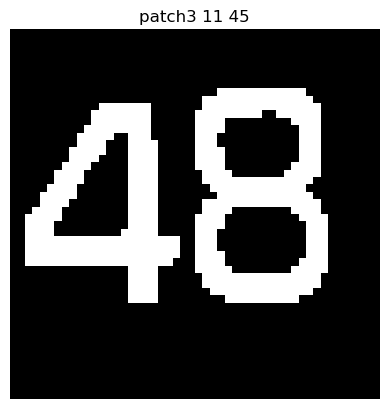

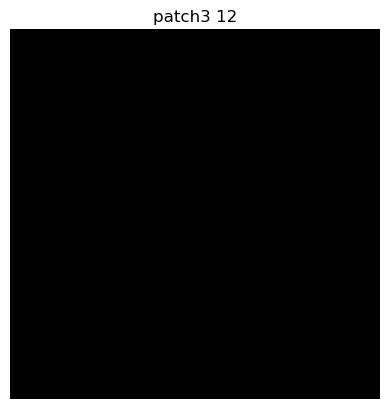

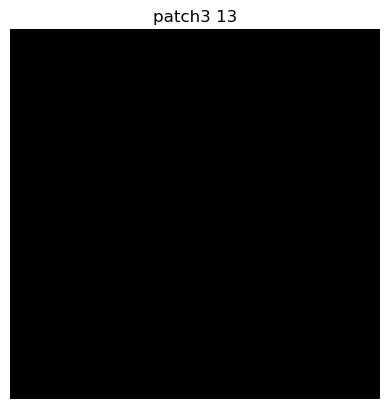

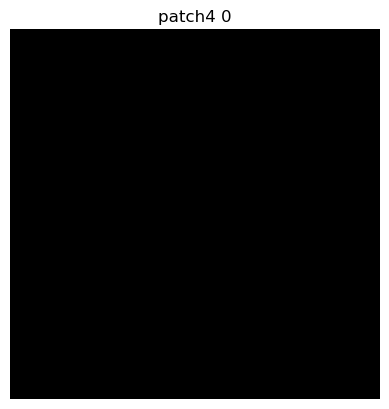

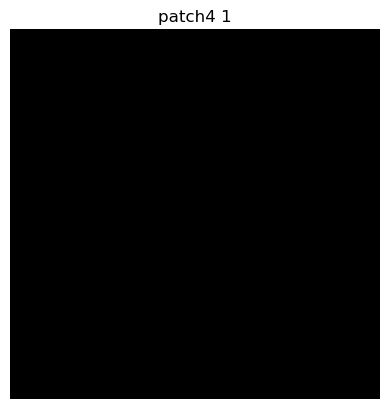

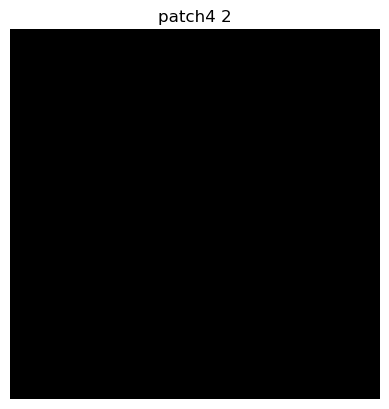

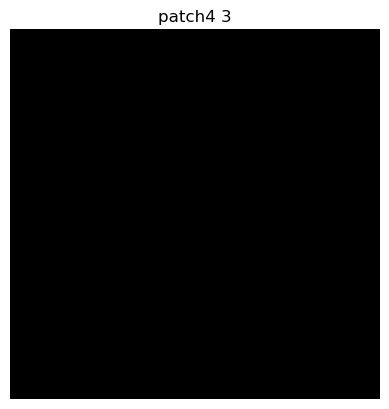

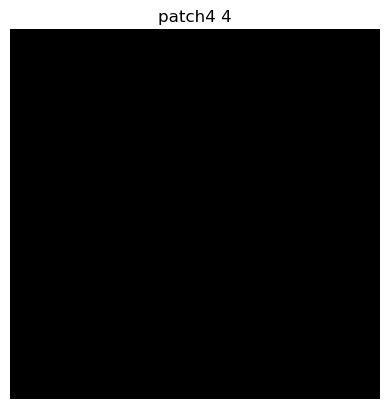

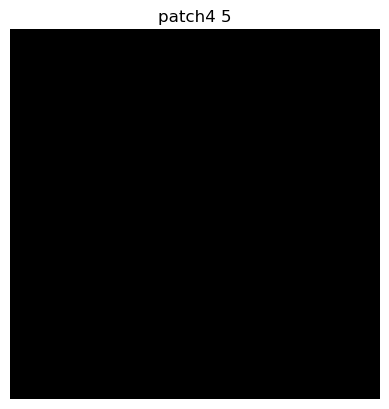

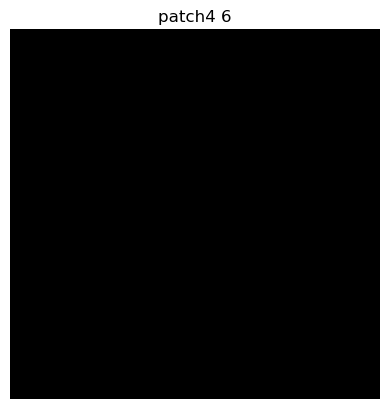

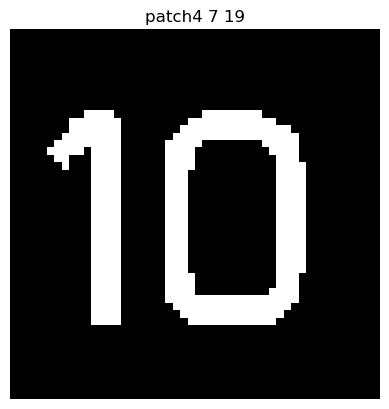

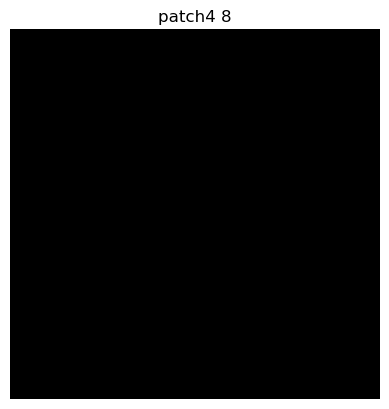

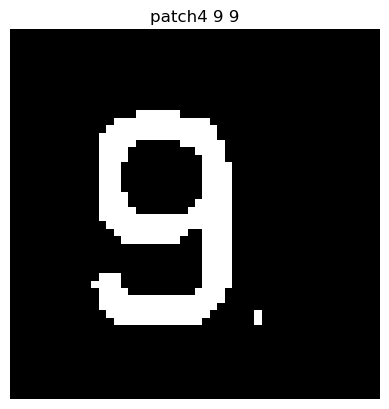

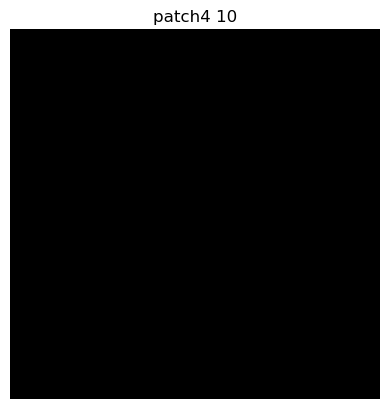

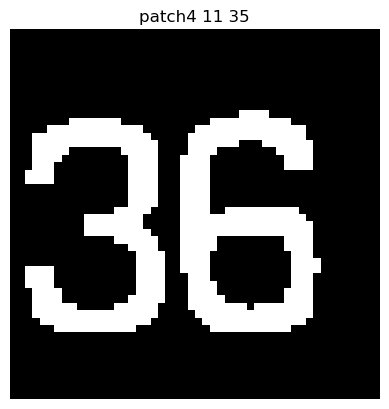

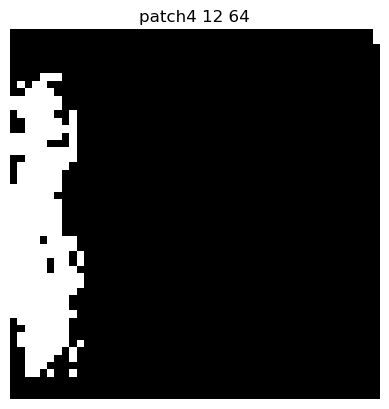

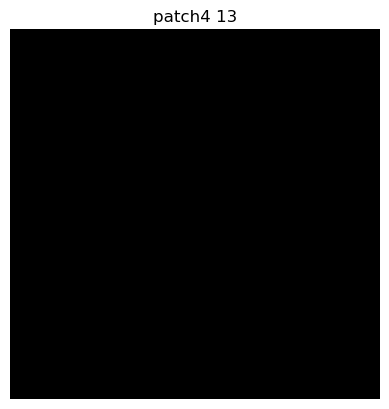

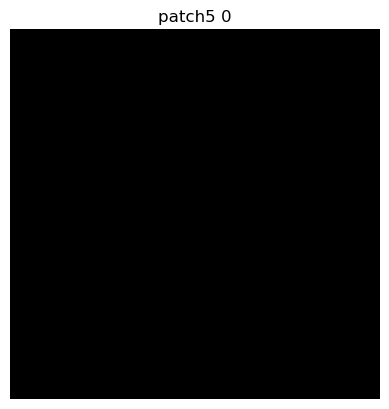

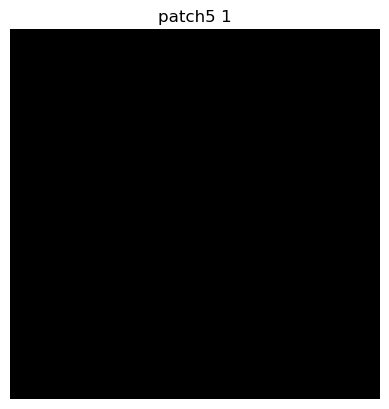

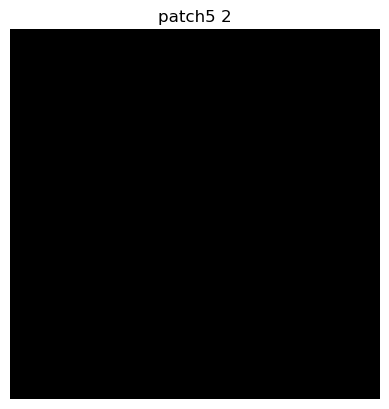

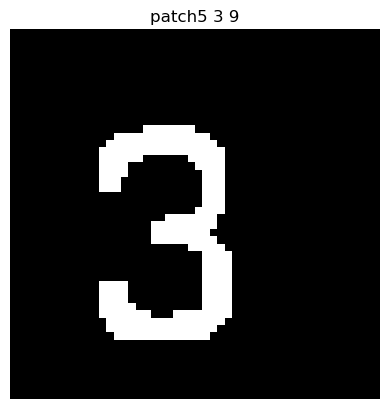

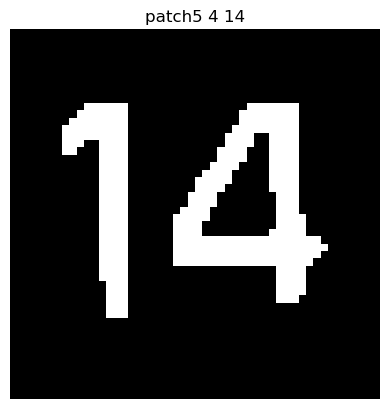

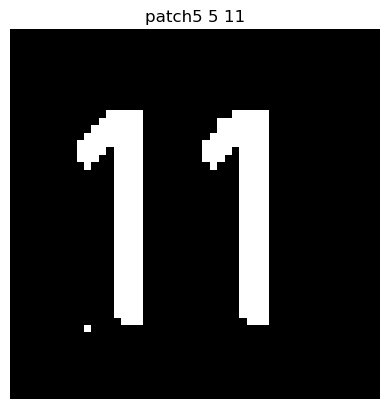

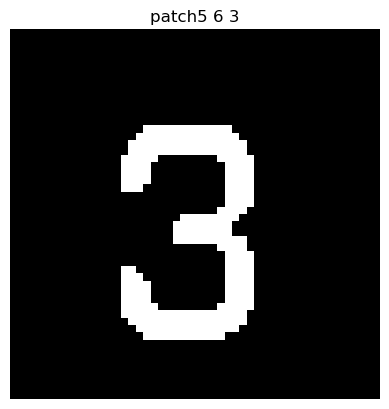

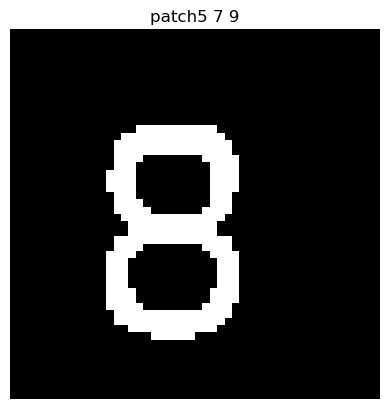

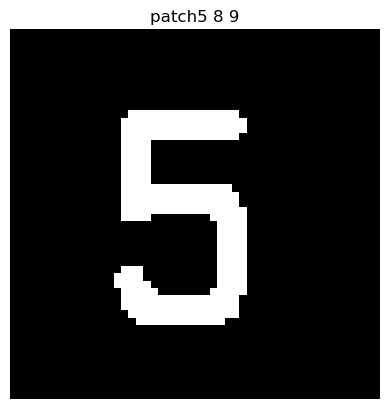

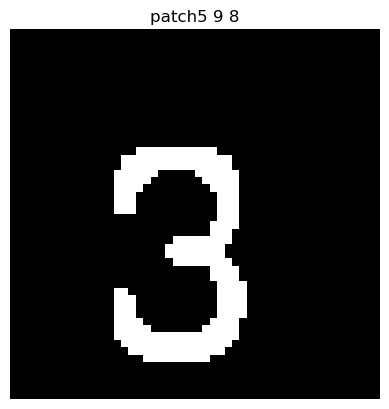

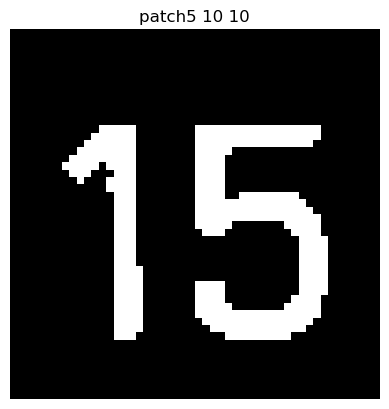

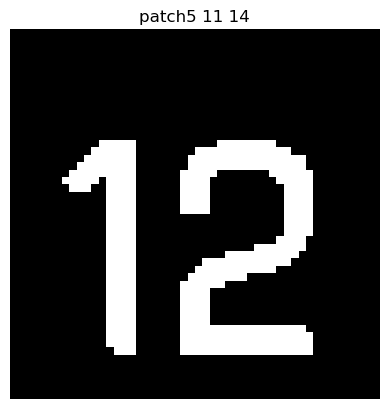

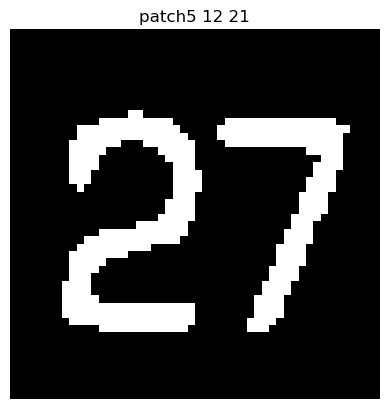

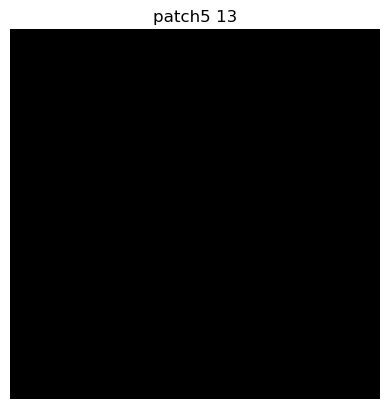

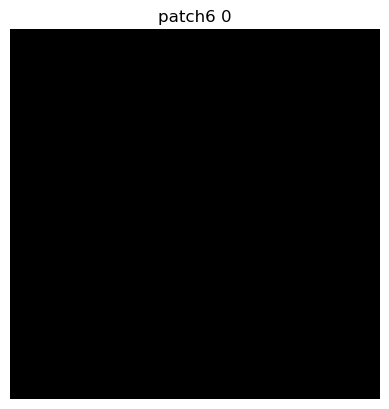

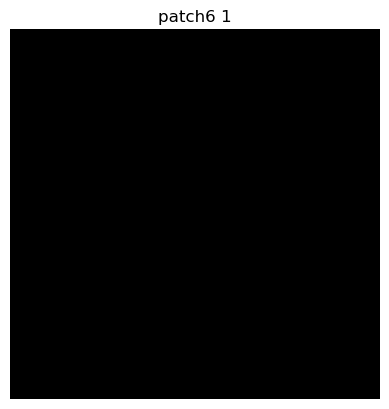

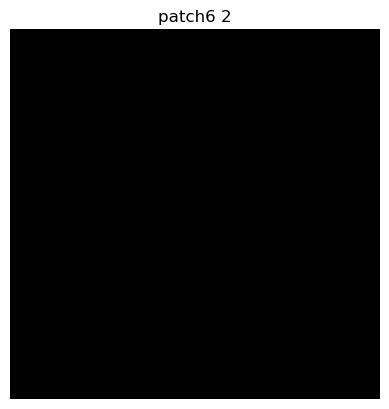

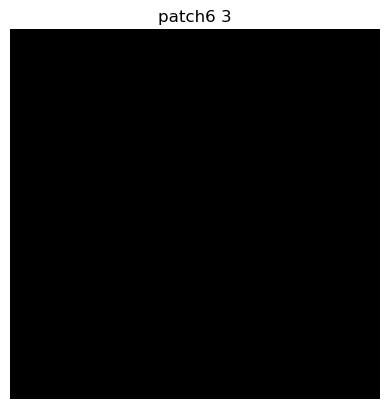

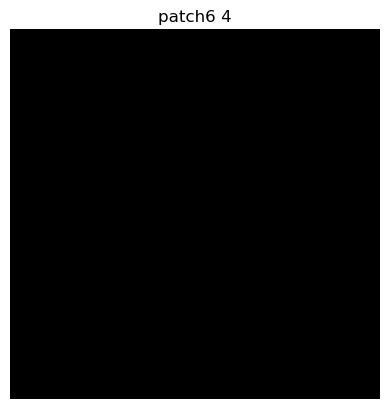

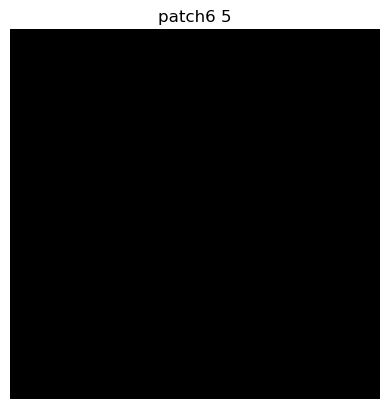

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


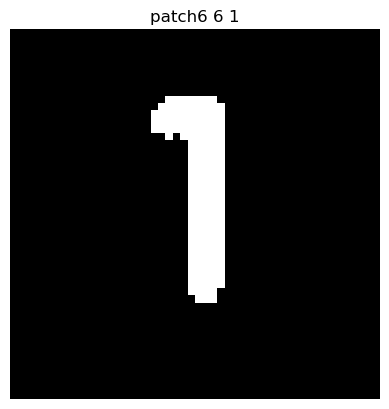

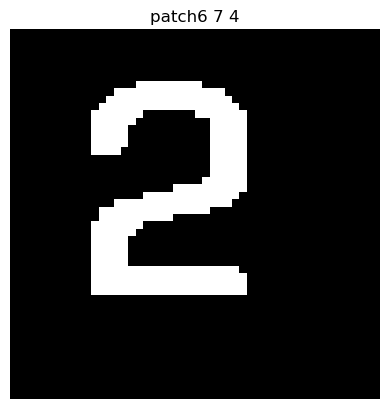

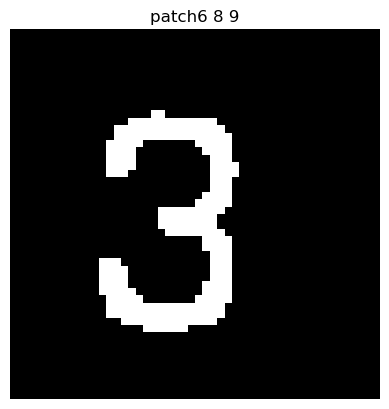

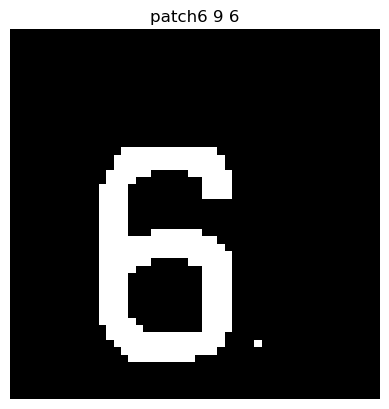

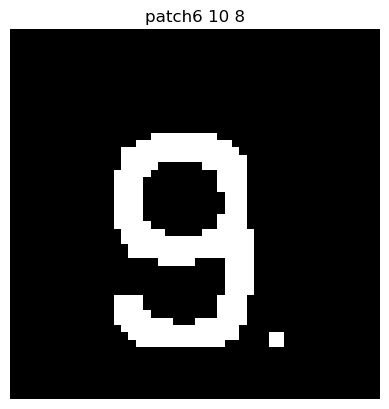

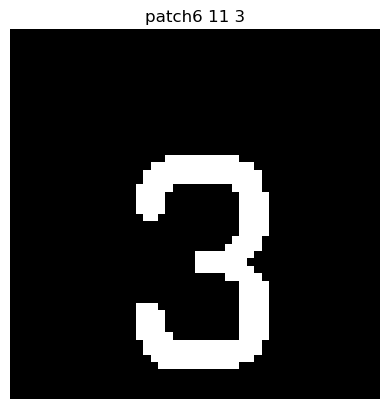

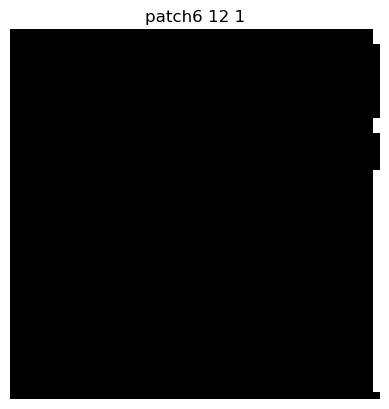

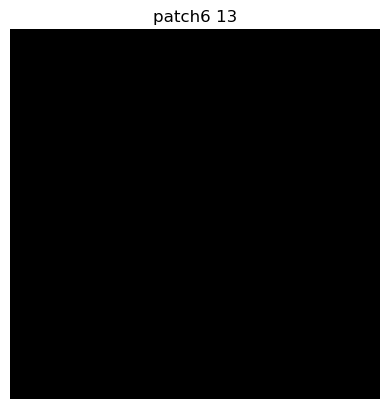

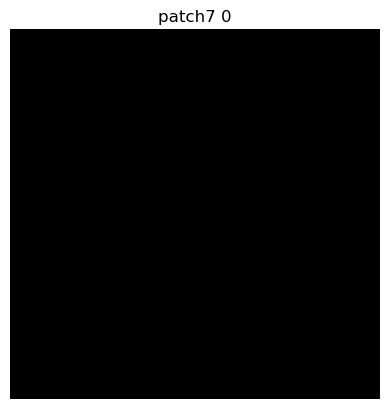

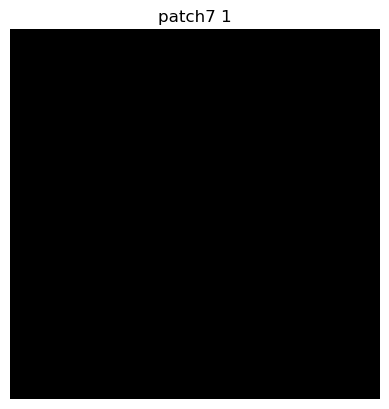

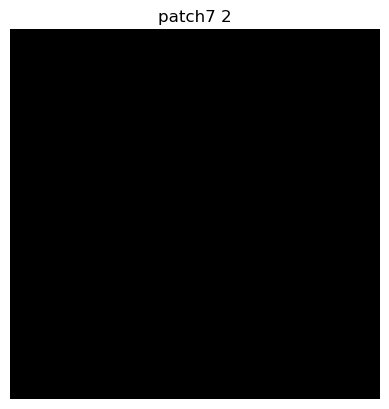

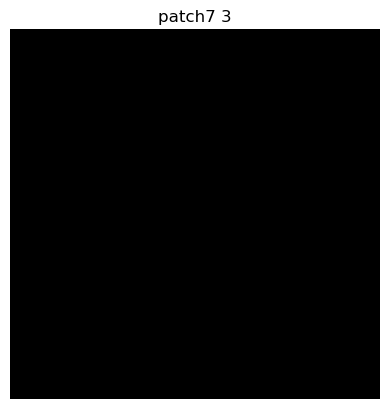

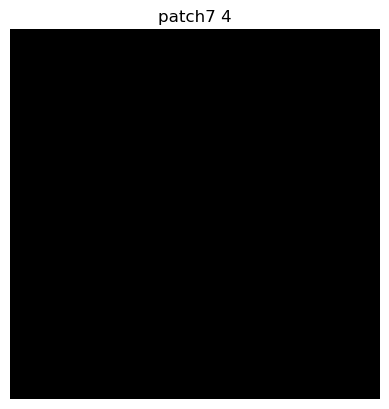

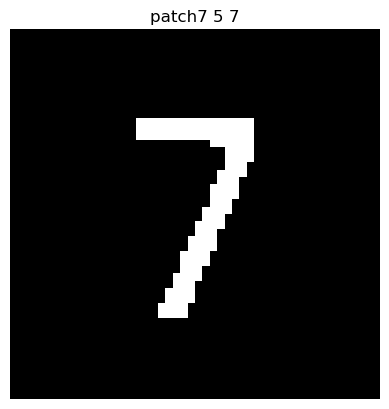

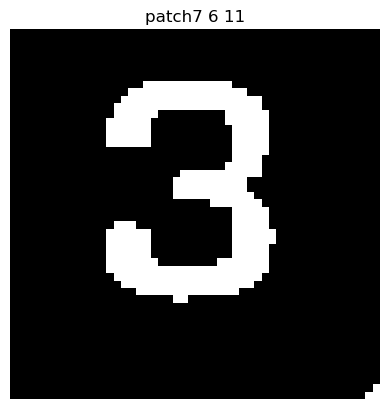

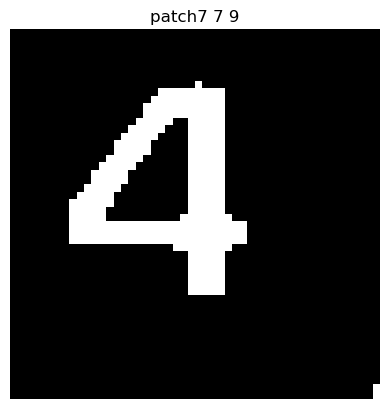

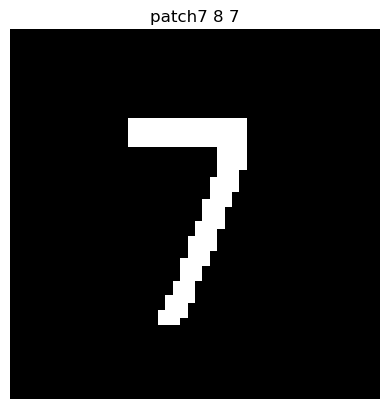

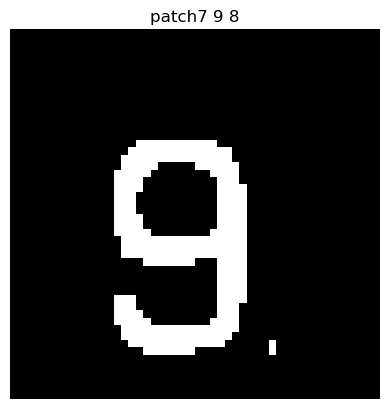

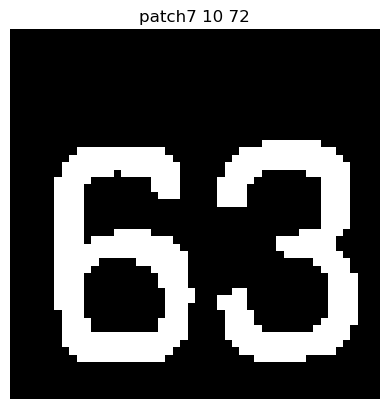

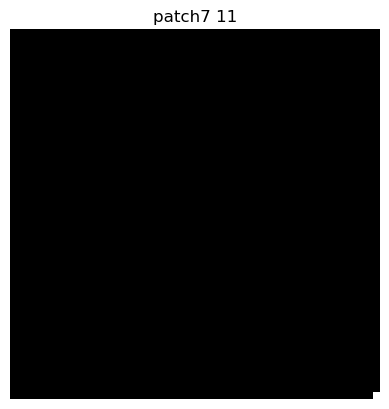

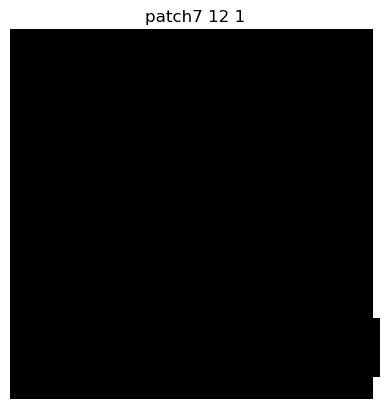

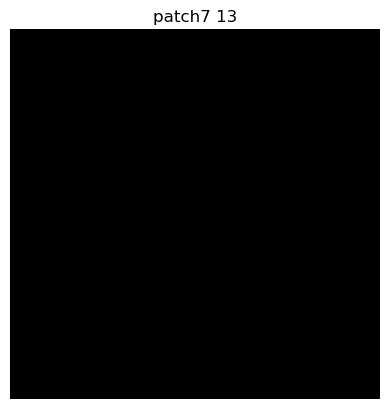

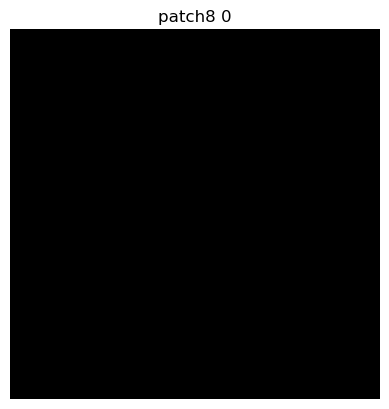

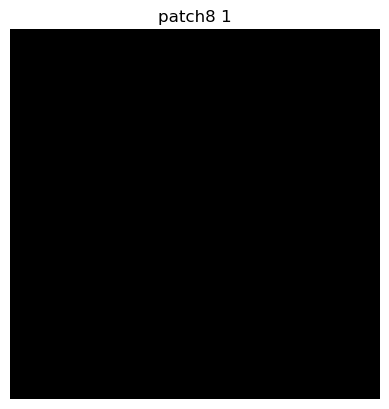

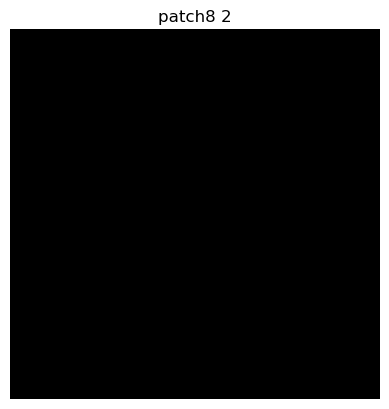

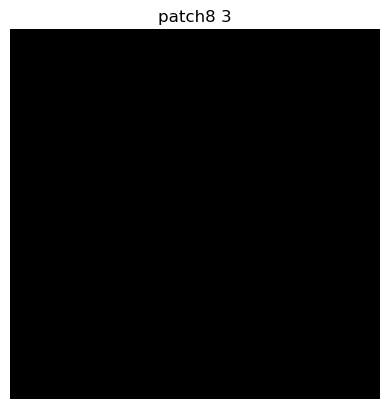

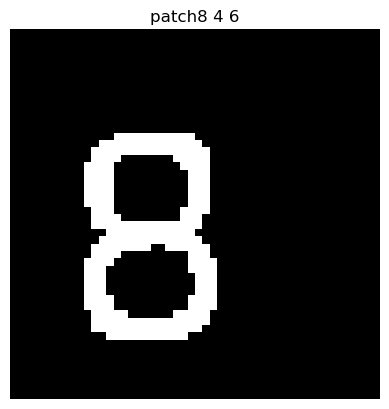

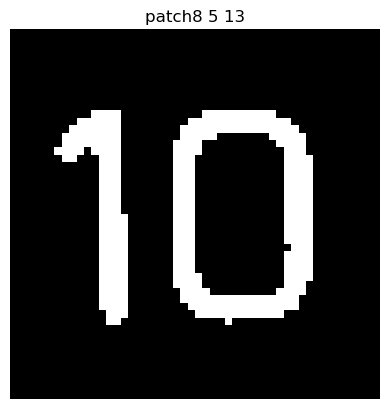

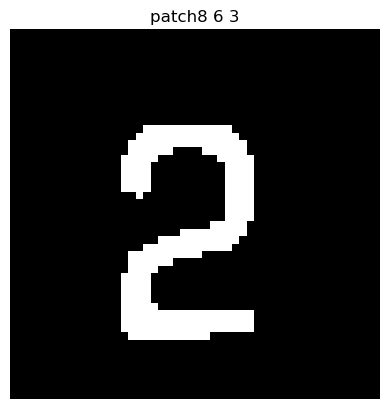

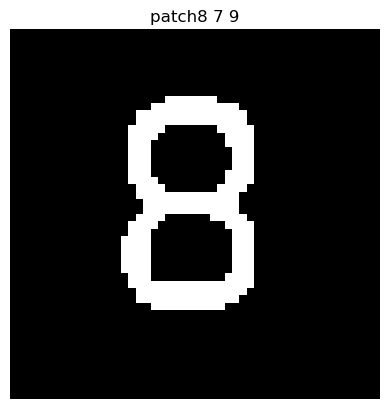

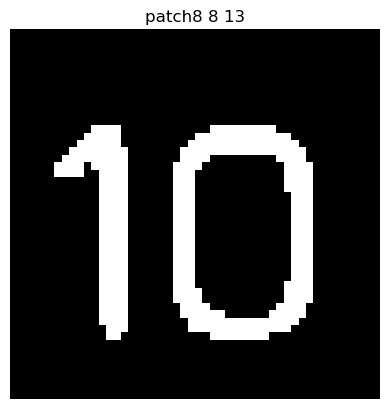

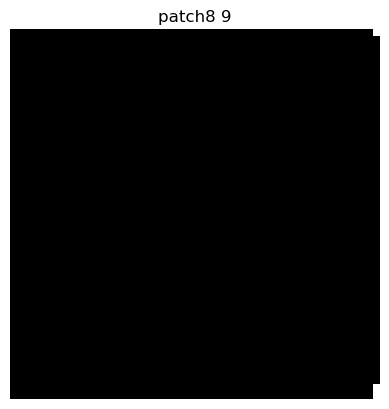

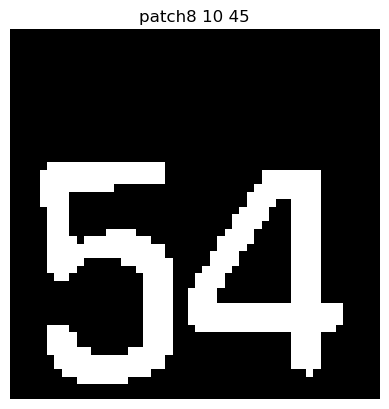

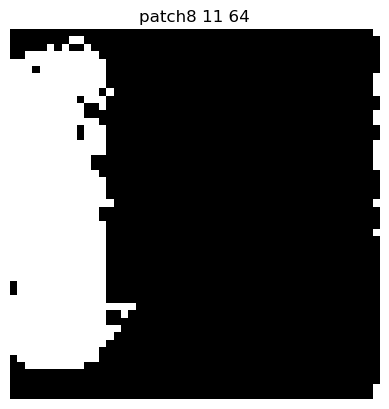

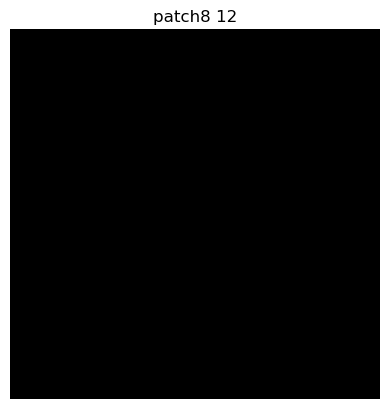

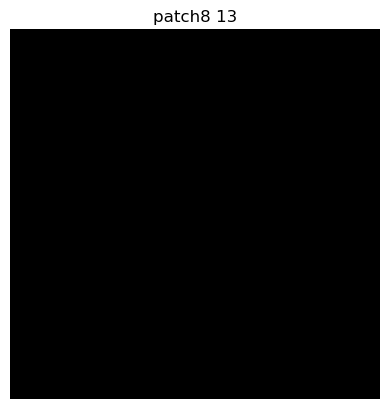

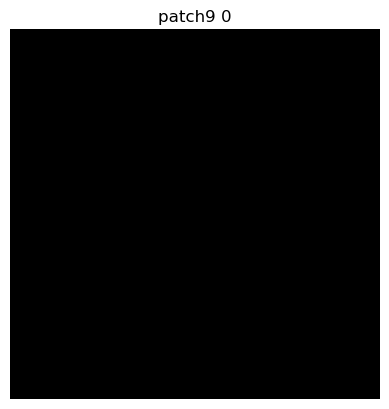

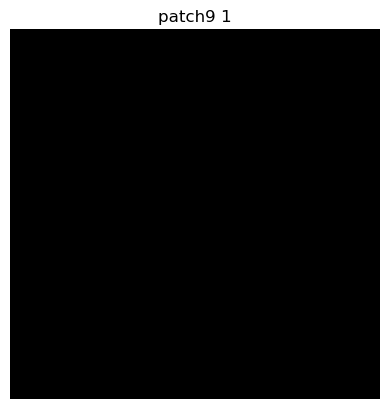

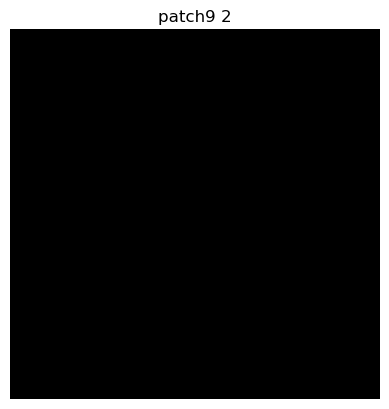

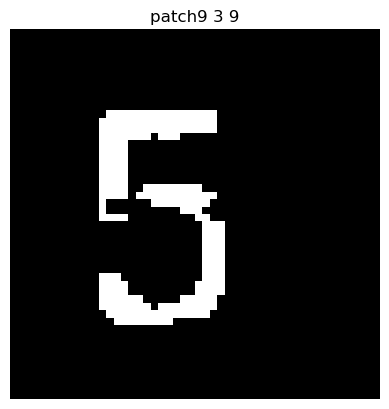

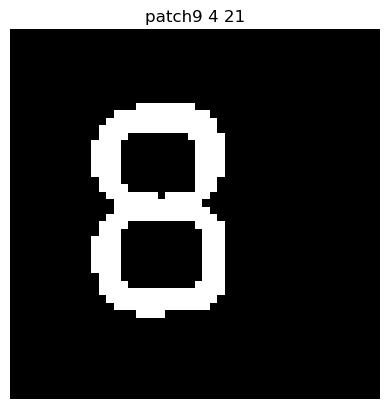

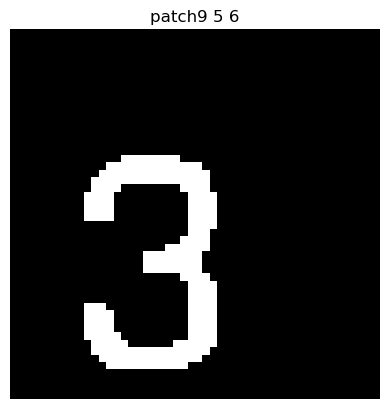

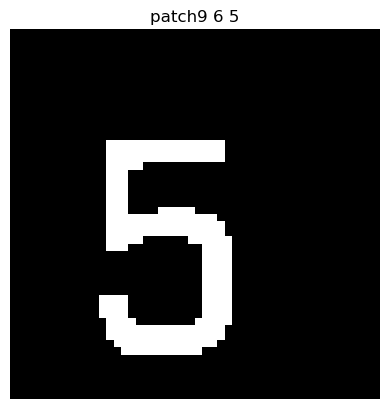

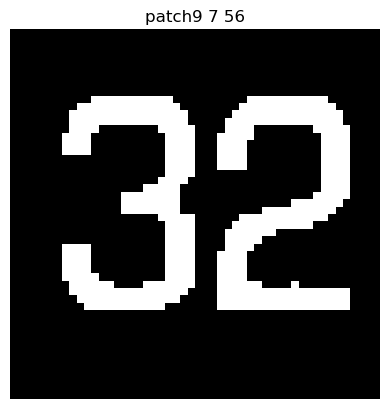

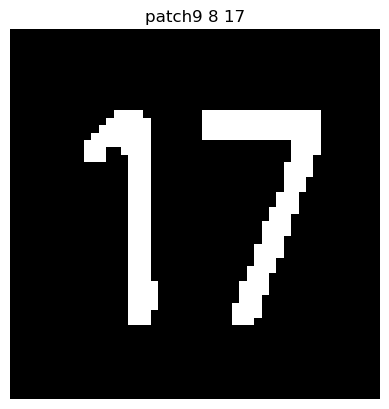

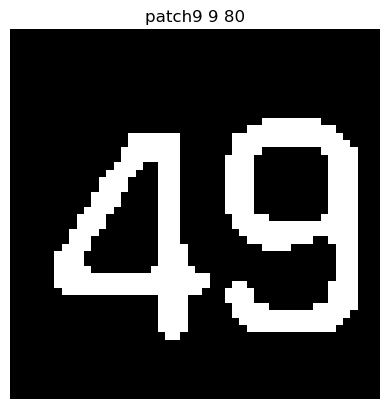

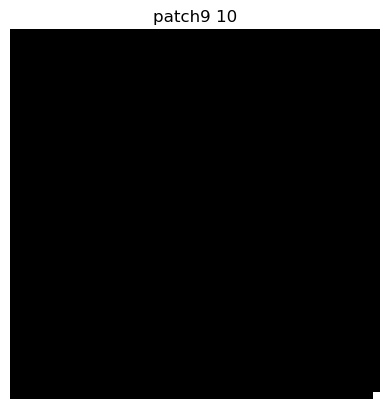

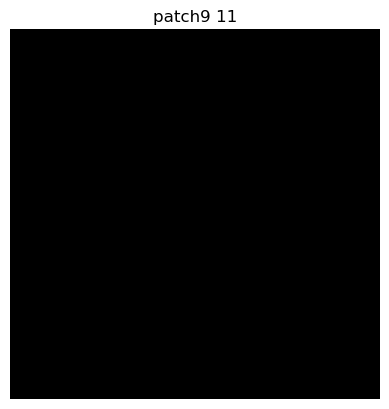

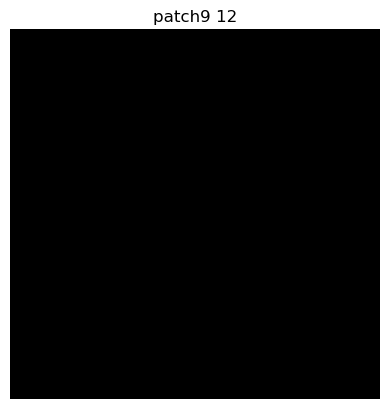

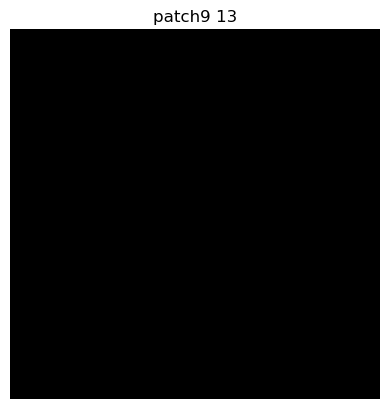

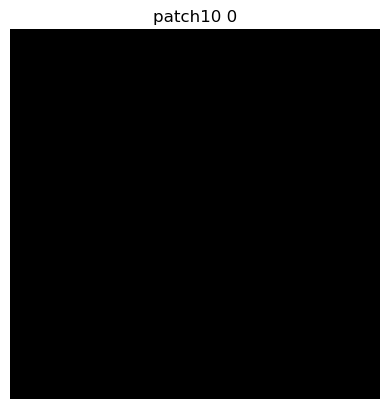

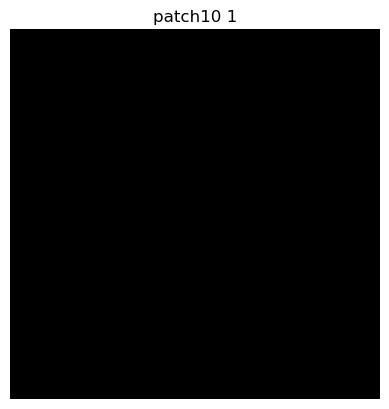

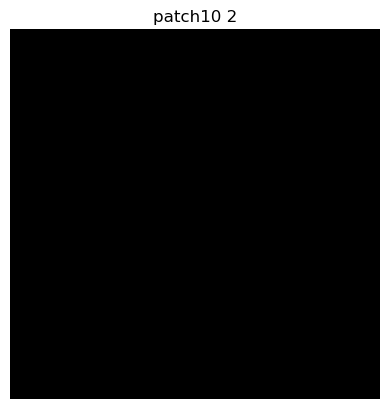

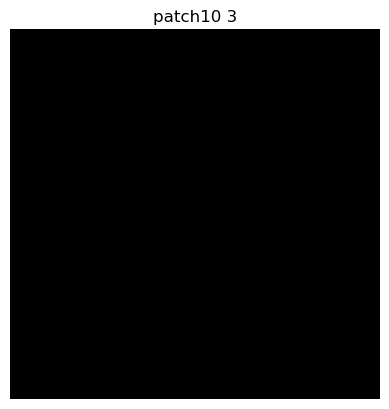

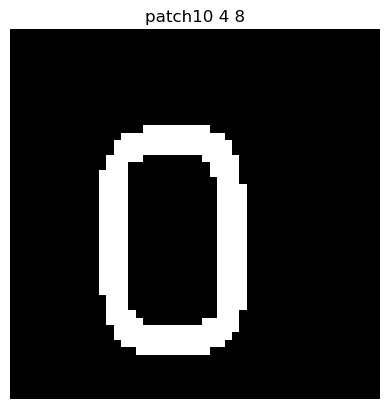

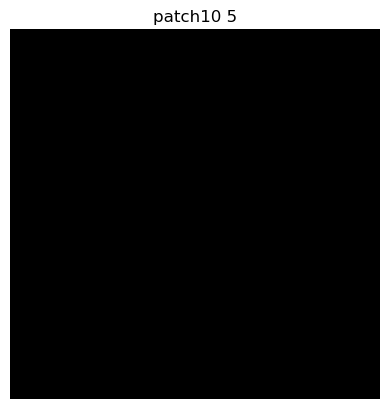

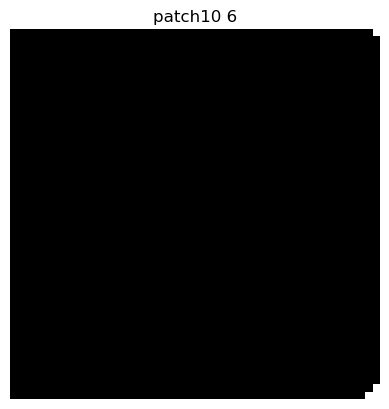

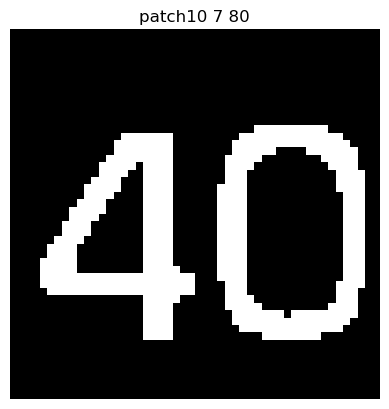

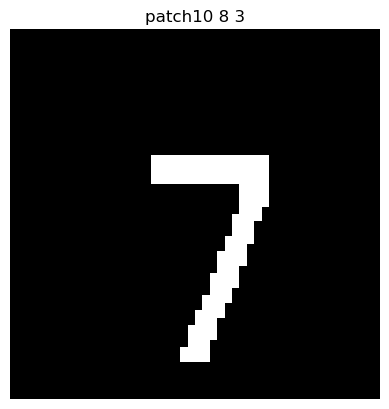

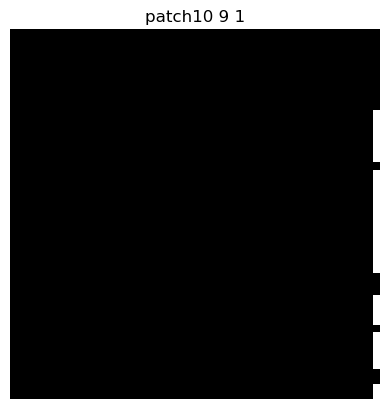

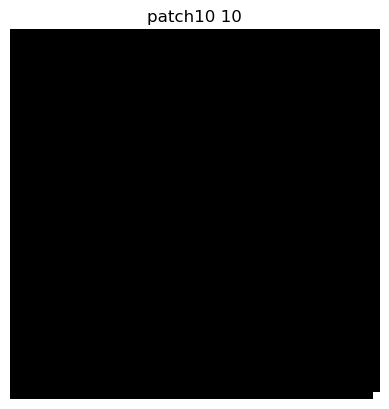

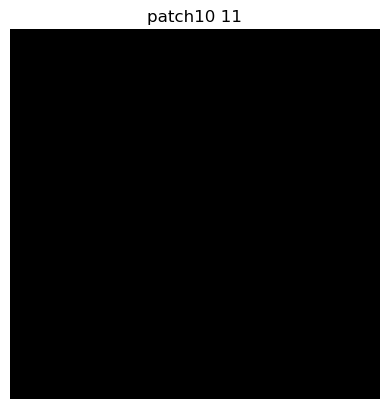

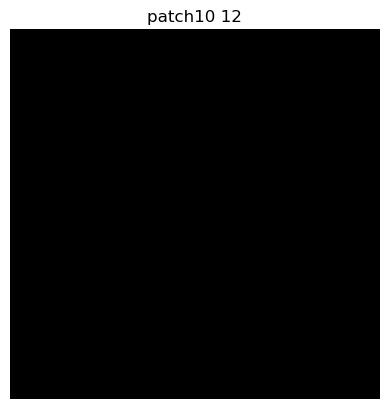

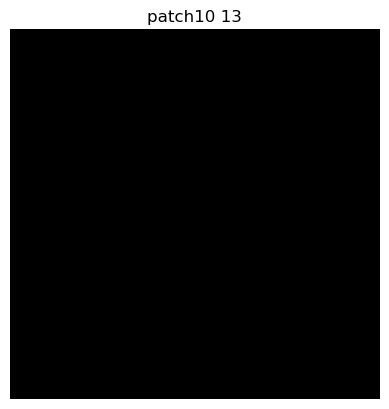

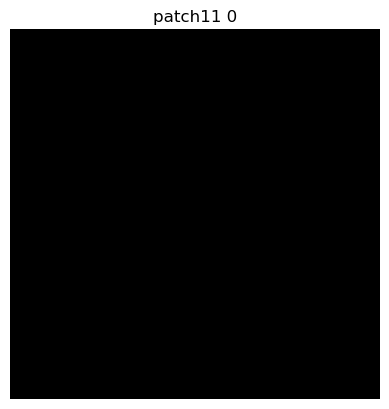

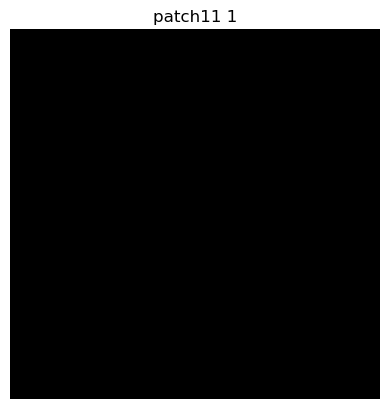

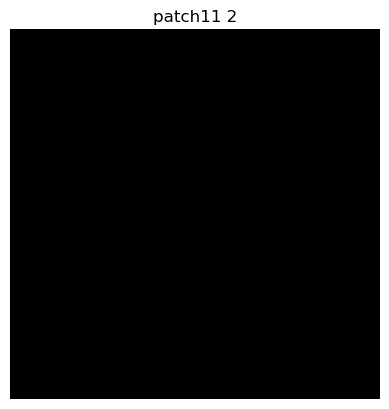

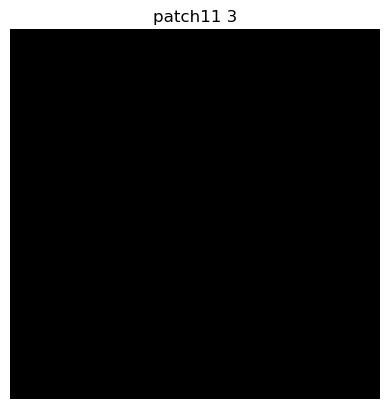

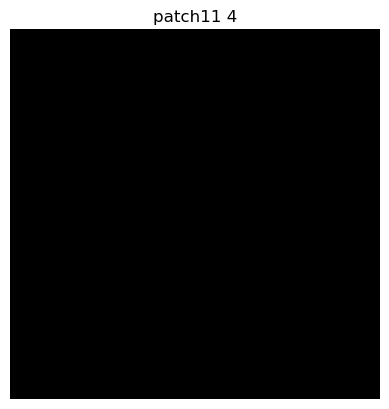

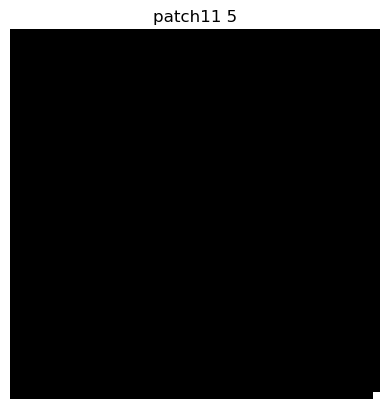

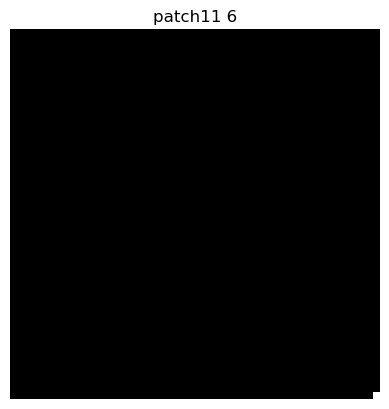

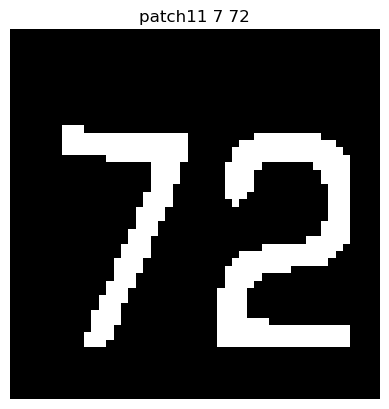

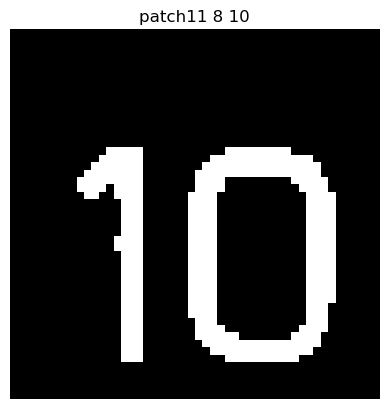

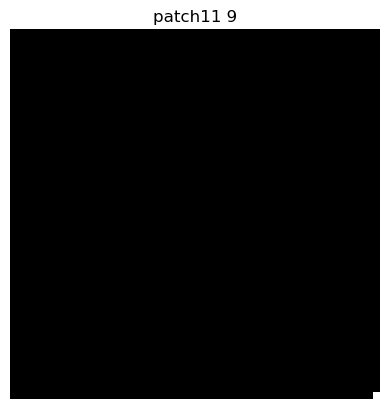

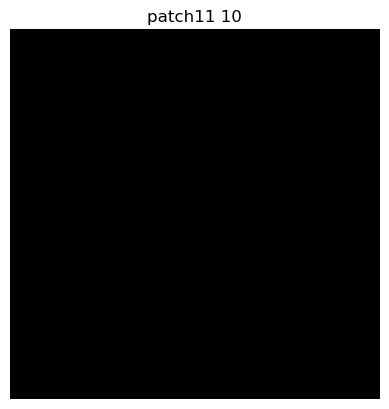

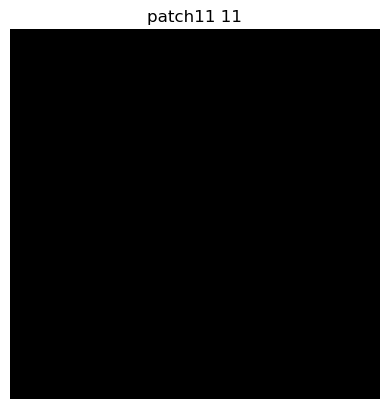

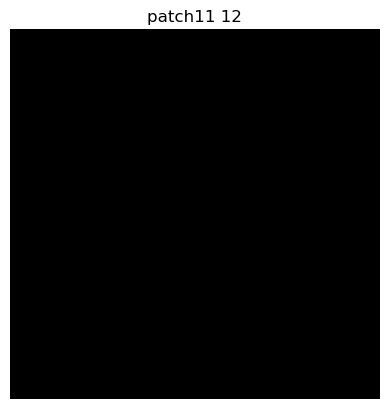

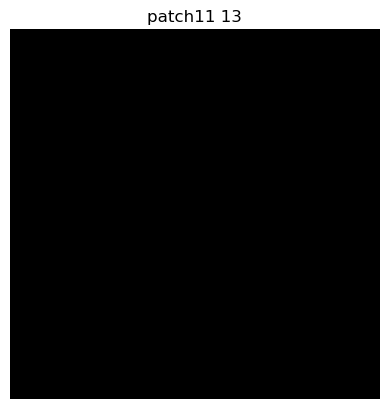

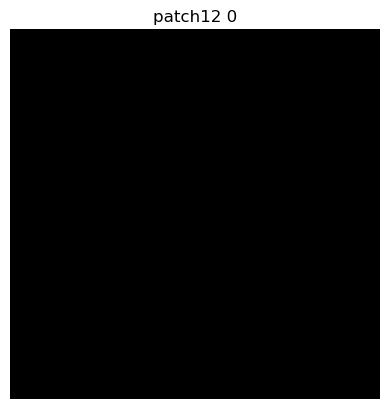

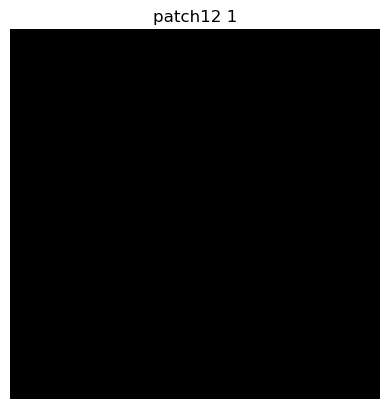

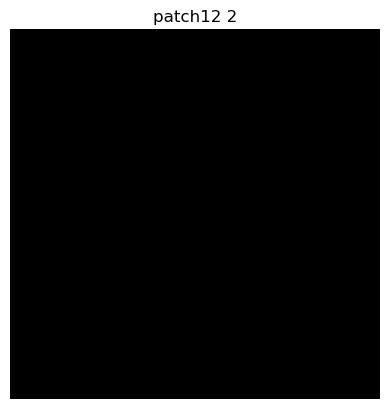

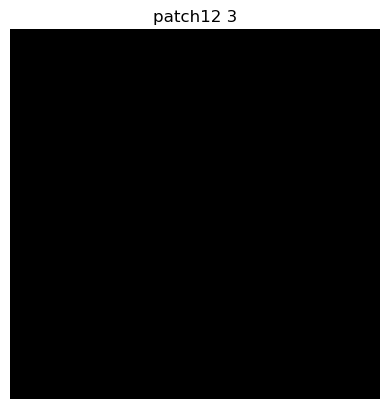

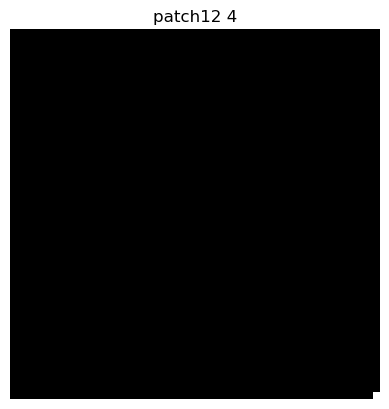

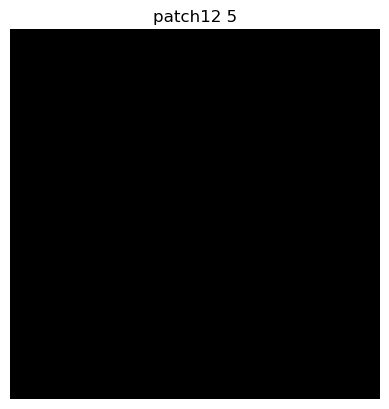

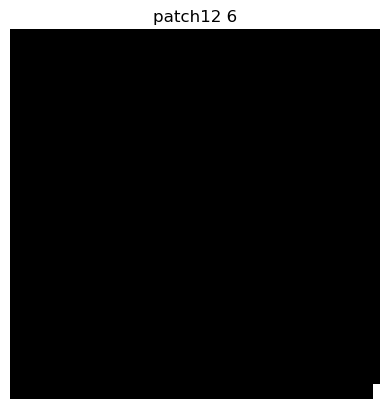

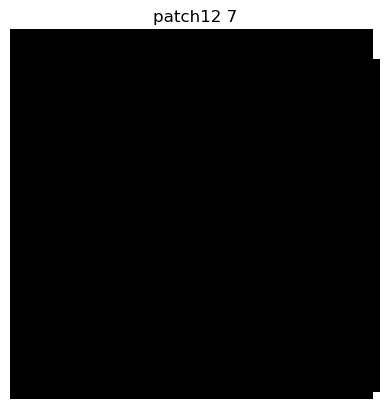

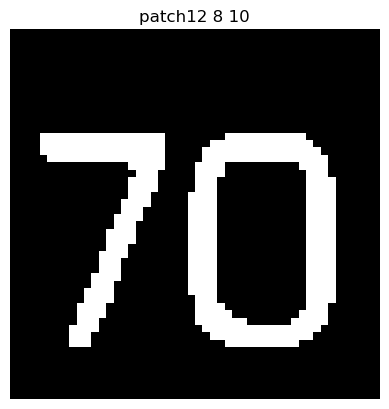

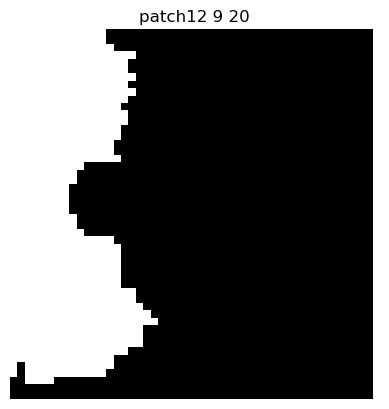

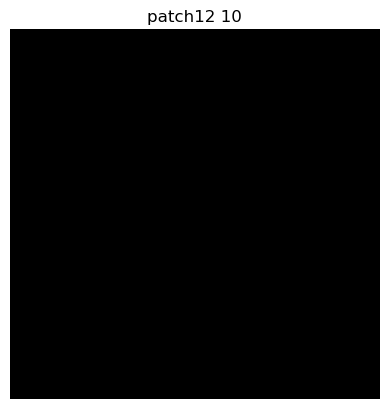

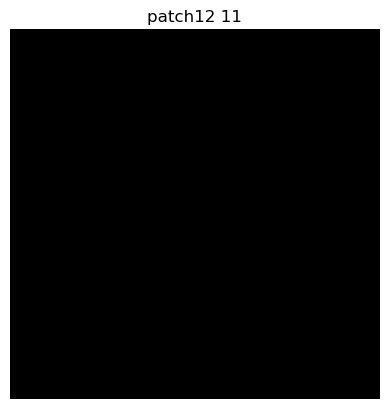

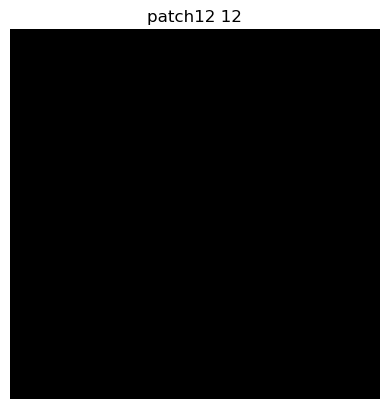

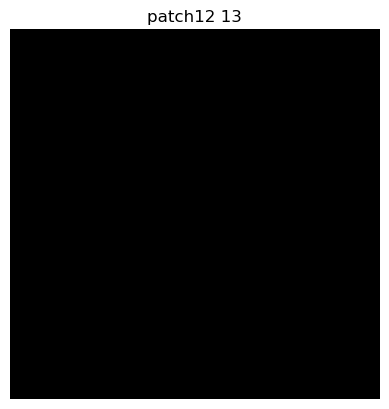

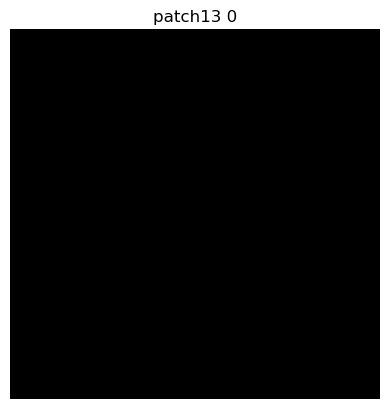

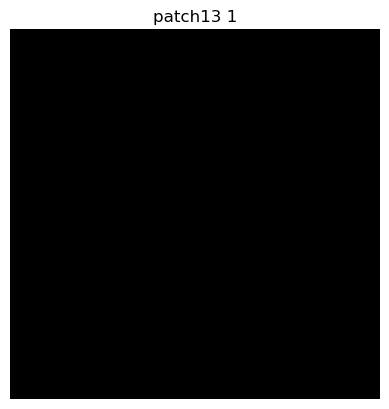

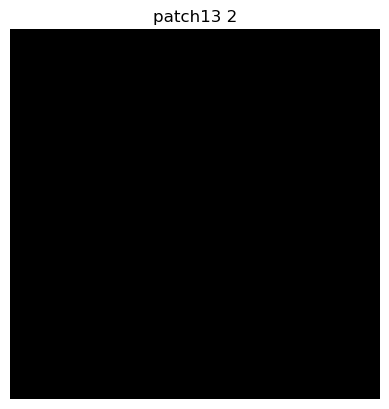

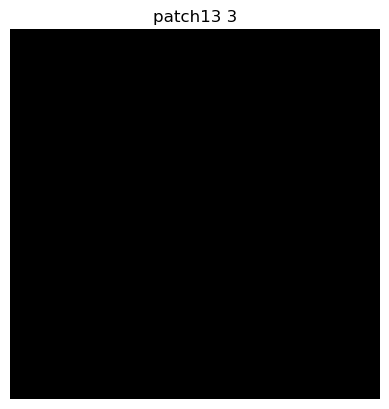

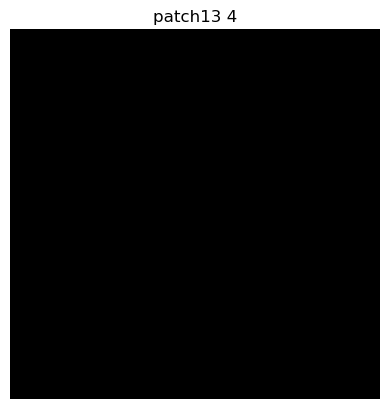

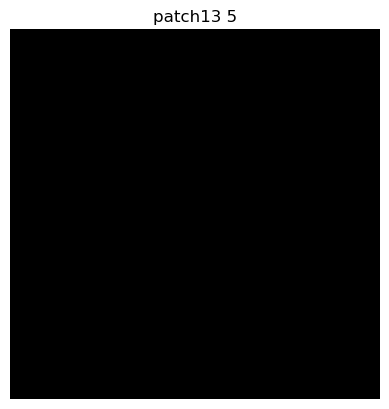

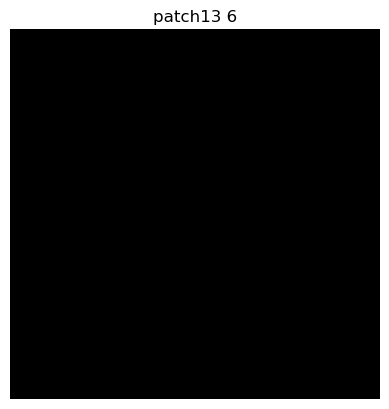

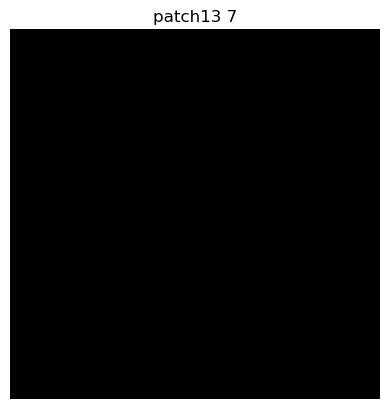

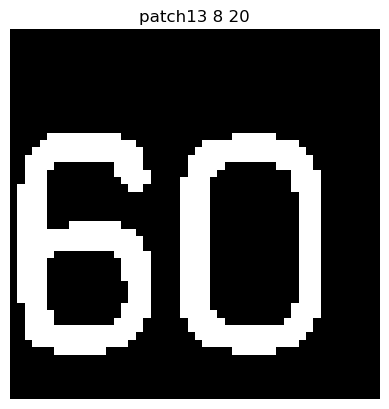

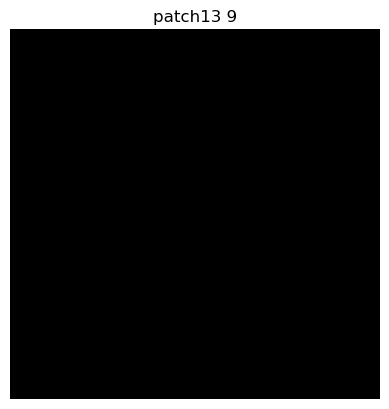

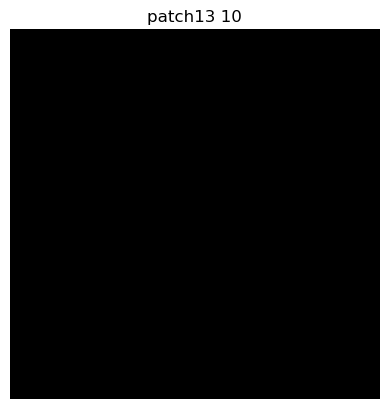

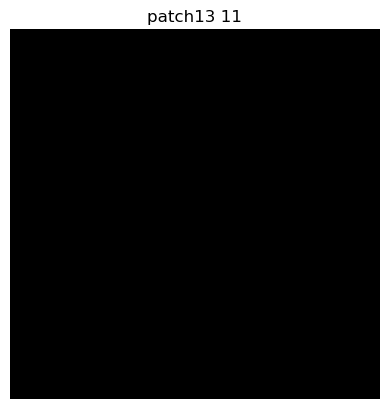

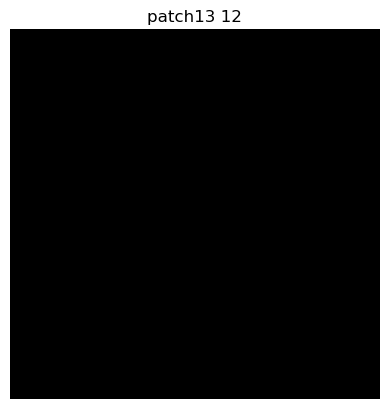

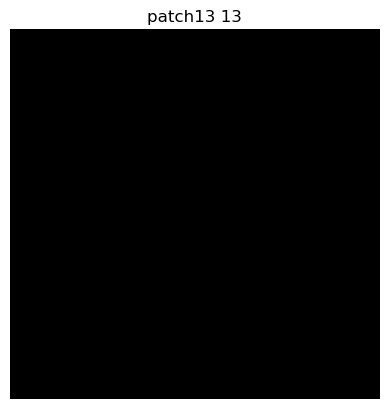

[(0, 7, 13),
 (0, 9, 81),
 (1, 7, 15),
 (1, 9, 6),
 (2, 7, 16),
 (2, 8, 64),
 (2, 9, 9),
 (3, 7, 63),
 (3, 9, 6),
 (3, 11, 45),
 (4, 7, 19),
 (4, 9, 9),
 (4, 11, 35),
 (4, 12, 64),
 (5, 3, 9),
 (5, 4, 14),
 (5, 5, 11),
 (5, 6, 3),
 (5, 7, 9),
 (5, 8, 9),
 (5, 9, 8),
 (5, 10, 10),
 (5, 11, 14),
 (5, 12, 21),
 (6, 6, 1),
 (6, 7, 4),
 (6, 8, 9),
 (6, 9, 6),
 (6, 10, 8),
 (6, 11, 3),
 (6, 12, 1),
 (7, 5, 7),
 (7, 6, 11),
 (7, 7, 9),
 (7, 8, 7),
 (7, 9, 8),
 (7, 10, 72),
 (7, 12, 1),
 (8, 4, 6),
 (8, 5, 13),
 (8, 6, 3),
 (8, 7, 9),
 (8, 8, 13),
 (8, 10, 45),
 (8, 11, 64),
 (9, 3, 9),
 (9, 4, 21),
 (9, 5, 6),
 (9, 6, 5),
 (9, 7, 56),
 (9, 8, 17),
 (9, 9, 80),
 (10, 4, 8),
 (10, 7, 80),
 (10, 8, 3),
 (10, 9, 1),
 (11, 7, 72),
 (11, 8, 10),
 (12, 8, 10),
 (12, 9, 20),
 (13, 8, 20)]

In [89]:
img = relevant_game_tables[49]
img = cv.cvtColor(img, cv.COLO1R_BGR2GRAY)
_, img = cv.threshold(img,80,255,cv.THRESH_BINARY_INV)
show_image_cv("ceva",img)

get_number_pos(img,5)

In [74]:
show_image_cv("ceva",img)